## ***FINE TUNING***

 ___GOAL___. <br>
In this notebook, the __fine tuning__ approach is performed for the dataset https://www.kaggle.com/moltean/fruits. This is the last technique that we want to carry out in order to explore different solutions changing the complexity of our candidate models.  

### __SETTING THE ENVIRONMENT__

In [ ]:
!pip install split-folders

In [ ]:
# Import libraries.

import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

import splitfolders

from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras import Input, Model, Sequential
from keras import optimizers, losses, metrics
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.regularizers import l1, l2
from keras.utils import np_utils
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# check GPU.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 18 07:58:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **DATA IMPORT & PREPROCESSING**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time

# extract dataset.
!unzip drive/MyDrive/AML-Project/Dataset/fruit-360.zip

In [ ]:
splitfolders.ratio('fruits-360/Test', output = 'fruits-360/Test_Validation', seed = 1337, ratio = (0.5, 0.5))

Copying files: 22688 files [00:02, 8550.08 files/s]


***DATA AUGMENTATION & PREPROCESSING*** <br>
First of all, `vgg16.preprocess_input` function is applied to preprocess images as VGG16 required. It consists of converting images from RGB to GBR channel, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. <br>
Then, in order to generaize better, we performed data augmentation which defines augmented images used only in the training phase. It's important to underline that we didn't build other augmented images from the training set but, with the use of `flow_from_directory` function, we defined for each batch the same data but augmented. So, the number of training images remains the same. <br> 
The following data augmented transformation are used:
- `rotation_range = 45`: this choice is justified by the fact that images are rotated 90 degrees and around the 3rd axis. So, this is a compromise to have another point of view.
- `width_shift_range = 0.15` and `height_shift_range = 0.15`. 
- `zoom_range = [0.9, 1.5]`. It's noteworthy to underline that we tried also these values `zoom_range=[0.5, 1.05]`. We noted that the performance of the models remain the same but the models learn slowly: the loss functions decreases faster in the second case  meaning that the models catch patterns in the data in less time. 
- `horizontal_flip = True`
- `vertical_flip = True`
- `fill_mode = "constant"` with `cval = 255.0` which is used to fill pixels after `width_shift_range` and `height_shift_range` procedures. <br>


In [ ]:

#---  This pipeline is used for loading data and learning the model. 

class pipeline_fine_tuning:
  def __init__(self, dim, preprocess_input, path, learning_rate, random_state):
    '''
    Constructors of pipeline_fine_tuning class.

    Attributes
    ----------
    dim: array. 
        How to resize images (height, width, channel) in target_size of flow_from_directory. 
    preprocess_input: keras object.
        preprocess of images by the pre-trained net.  
    path: str
        path of the root folder which contains training and test sets.
    learning_rate: float
        learning rate for the training phase.
    random_state: int
        random state for stochastic functions.
    '''
    self.H = dim[0] # height of resized images.
    self.W = dim[1] # width of resized images.
    self.C = dim[2] # rgb or greyscale.

    self.preprocess_input = preprocess_input # preprocess of the pre-trained net.
    self.path = path # path of train and test set. 
    self.learning_rate = learning_rate 
  
    self.random_state = random_state

  def split_train_val_test(self, batch_size, data_augm):
    '''
    Load train, validation and test set. Data augmentation process is applied only to training data.
    Preprocess input is applied and then, the scaling part is carried out because the output isn't standardized.

    Attributes
    ----------
    batch_size: int
        Number of images to load and to use in order to perform the training algorithm.
    '''

    self.batch_size = batch_size

    #--- Training set.

    # shuffle vs. validation__split: prima fa il validation_split, poi lo shuffle ED è SBAGLIATISSIMO!
    # -> meglio dividere le cartelle
    if data_augm == 1:
       print('Data augmentation')
       train_processing = ImageDataGenerator(
                                          rotation_range = 45,
                                          width_shift_range = 0.15,
                                          height_shift_range = 0.15,
                                          zoom_range = [0.9, 1.5],
                                          horizontal_flip = True, 
                                          vertical_flip = True,
                                          fill_mode =  'constant',
                                          cval = 255.0,
                                          preprocessing_function = self.preprocess_input
                                          )
    else:
      print('Without data augmentation')
      train_processing = ImageDataGenerator(preprocessing_function = self.preprocess_input)

    self.train_generator = train_processing.flow_from_directory(
        directory = self.path + 'Training',
        color_mode = self.C,         
        batch_size = self.batch_size,
        target_size = (self.H, self.W),  
        class_mode = "categorical",
        shuffle = True,
        seed = self.random_state
        )
    
    #--- Validation and Test set. 

    # uso questo generatore per NON FARE DATA AUGMENTATION ed ottenere il validation e test.
    test_processing = ImageDataGenerator(preprocessing_function = self.preprocess_input)
    
    self.val_generator = test_processing.flow_from_directory(
        directory = self.path + 'Test_Validation/train',
        color_mode = self.C,         
        batch_size = self.batch_size,
        target_size = (self.H, self.W),  
        class_mode = "categorical",
        seed = self.random_state
        )
      
    self.test_generator = test_processing.flow_from_directory(
        directory = self.path + 'Test_Validation/val',
        color_mode = self.C,
        batch_size = self.batch_size,
        target_size = (self.H, self.W),
        class_mode = "categorical",
        seed = self.random_state
        )


  def fine_tuning(self, model):
    '''
    Save fine-tuning architecture.

    Attributes
    ----------
    model: keras object.  
        Fine tuning of pretrained vgg16.  
    '''
    self.new_model = model

  def compile(self, epochs, clbks):
    '''
    Compile model.

    Attributes
    ----------
    epochs: int
        Number of epochs for the training set. 
    clbk: list.
        Callbacks for keras fit function.
    '''
    self.epochs = epochs

    self.new_model.compile(loss = losses.categorical_crossentropy,
                           optimizer= optimizers.Adam(lr = self.learning_rate),
                           metrics = categorical_accuracy
                           )
    
    if len(clbks):
      self.H = self.new_model.fit(self.train_generator,
                                  batch_size = self.batch_size,
                                  epochs = self.epochs,
                                  validation_data = self.val_generator, 
                                  callbacks = clbks
                                  )
    else:
      self.H = self.new_model.fit(self.train_generator,
                                batch_size = self.batch_size,
                                epochs = self.epochs,
                                validation_data = self.val_generator
                                )
    
  def evaluation(self):
    '''
    Evaluation the model: compute the categorical accuracy and plot the performance of the model.
    '''

    N = np.arange(0, len(self.H.history['val_categorical_accuracy'])) # epochs.

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

    ax1.plot(N, self.H.history["loss"], label="Train Loss", color = 'blue')
    ax1.plot(N, self.H.history["val_loss"], label="Val Loss", color = 'orange')
    ax1.set_title("Loss performance")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(N, self.H.history["categorical_accuracy"], label="Train Categorical Accuracy", color = 'blue')
    ax2.plot(N, self.H.history["val_categorical_accuracy"], label="Val Categorical Accuracy", color = 'orange')
    ax2.set_title("Categorical accuracy performance")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Categorical accuracy")
    ax2.legend()

    plt.show();

    result = self.new_model.evaluate(self.test_generator)
    print(f"Final accuracy: {result[1]}")

In [ ]:
# Constants. 

PATH = 'fruits-360/'

HEIGHT = 100
WIDTH = 100
CHANNEL = "rgb"

RANDOM_STATE = 0

# Reasonable hyperparameter to start modeling. 
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-4

plt.style.use("ggplot")

### ***EXPLORATION: VGG16***

---

___PRETRAINED MODEL___. <br>
For this purpose, we chose the __pretrained VGG16 with imagenet weights__ because it's a common choice for this type of task. 
The image below shows the architecture of this net which is made up of different convolutional and pooling layers and finally, a fully connected net. 

k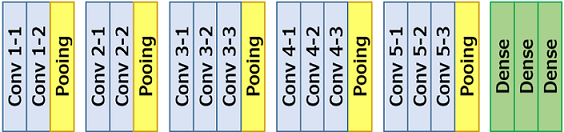

In [ ]:
from tensorflow.keras.applications import vgg16

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

preprocess = vgg16.preprocess_input


#### ***FINE TUNING WITH INCLUDE_TOP = FALSE***

___FINE TUNING STRATEGIES___ <br>
In order to classify the fruits, we decided to follow two main approaches: <br>
1. _Drop the last dense layers and add one or more dense layers learned by our data as sketched in the image below_. <br>
This choice is justified by the fact that some high-level features extract from the imagenet dataset shouldn't be different from the ones that we are looking for. Indeed, the imagenet dataset provides images with 1000 different labels which include also some food categories such as apples, pineapples, bananas, pomegranate etc. So, it's reasonable to train only the new fully-connected layers of the model. 
<br>
Once the data augmentation is done, we start with the simplest model in order to have a performance baseline which we want to improve with the introduction of different regularization techniques, such as $L_1$, $L_2$ and Droput, and different architectures. 

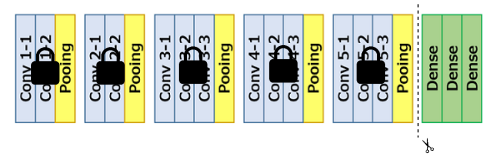

In [ ]:
#-- BASE MODEL.

conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT, WIDTH, 3 if CHANNEL == 'rgb' else 1))

for layer in conv_base.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
# Define object.
vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, LEARNING_RATE, RANDOM_STATE)

##### __WITHOUT DATA AUGMENTATION__

In [ ]:
# Split dataset.
vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 0)

Without data augmentation
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


In [ ]:
# vediamo come sono le immagini aumentate.

for (elem, etichetta) in vgg16_pipe.train_generator:
  l = elem
  break

# i valori sono normalizzati. 
l[0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


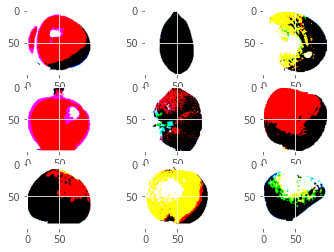

In [ ]:

#-- Images are strange because they are preprocessed by VGG16. 

for i in range(9):
  plt.subplot(330 + 1 + i)
  b,g,r = cv2.split(l[i])       
  rgb_img = cv2.merge([r,g,b])
  plt.imshow(rgb_img)     

In [ ]:
num_classes = len(np.unique(vgg16_pipe.test_generator.labels))
print(f"Numero di classi: {num_classes}")

Numero di classi: 131


###### ***ONLY OUTPUT***

In [ ]:
#-- FINE-TUNING.

# without data augmentation.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131)               603779    
Total params: 15,318,467
Trainable params: 603,779
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 58s 109ms/step - loss: 11.5943 - categorical_accuracy: 0.4642 - val_loss: 1.2801 - val_categorical_accuracy: 0.8253
Epoch 2/20
529/529 [==============================] - 57s 108ms/step - loss: 0.0378 - categorical_accuracy: 0.9897 - val_loss: 0.9241 - val_categorical_accuracy: 0.8724
Epoch 3/20
529/529 [==============================] - 57s 108ms/step - loss: 0.0049 - categorical_accuracy: 0.9991 - val_loss: 0.8232 - val_categorical_accuracy: 0.8878
Epoch 4/20
529/529 [==============================] - 57s 108ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.7908 - val_categorical_accuracy: 0.8940
Epoch 5/20
529/529 [==============================] - 57s 108ms/step - loss: 9.1023e-04 - categorical_accuracy: 1.0000 - val_loss: 0.7587 - val_categorical_accuracy: 0.8964
Epoch 6/20
529/529 [==============================] - 57s 108ms/step - loss: 5.3317e-04 - categorical_accuracy: 1.0000 - val_loss: 0.7392 - val_catego

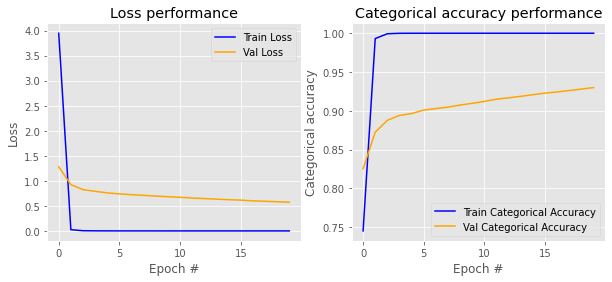

89/89 [==============================] - 8s 92ms/step - loss: 0.6558 - categorical_accuracy: 0.9281
Final accuracy: 0.928124725818634


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 NEURONS WITHOUT REGULARIZATION***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_3 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 1,213,571
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 57s 107ms/step - loss: 5.7612 - categorical_accuracy: 0.5951 - val_loss: 0.7079 - val_categorical_accuracy: 0.8754
Epoch 2/20
529/529 [==============================] - 56s 107ms/step - loss: 0.0121 - categorical_accuracy: 0.9983 - val_loss: 0.6135 - val_categorical_accuracy: 0.8988
Epoch 3/20
529/529 [==============================] - 56s 106ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.5786 - val_categorical_accuracy: 0.9058
Epoch 4/20
529/529 [==============================] - 56s 105ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.5539 - val_categorical_accuracy: 0.9114
Epoch 5/20
529/529 [==============================] - 56s 106ms/step - loss: 6.4429e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5386 - val_categorical_accuracy: 0.9151
Epoch 6/20
529/529 [==============================] - 56s 106ms/step - loss: 4.2685e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5288 - val_categor

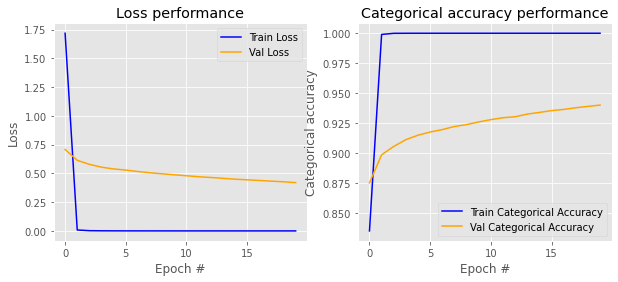

89/89 [==============================] - 8s 91ms/step - loss: 0.4552 - categorical_accuracy: 0.9383
Final accuracy: 0.938254177570343


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

In [ ]:
#-- BASE MODEL.

conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT, WIDTH, 3 if CHANNEL == 'rgb' else 1))

for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
# Define object.
vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, LEARNING_RATE, RANDOM_STATE)

In [ ]:
# Split dataset.
vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


In [ ]:
# vediamo come sono le immagini aumentate.

for (elem, etichetta) in vgg16_pipe.val_generator:
  l = elem
  break

# i valori sono normalizzati. 
l[0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


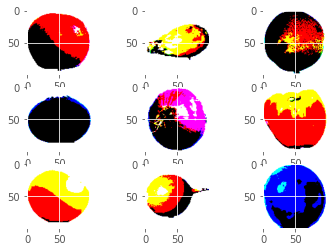

In [ ]:

#-- Images are strange because they are preprocessed by VGG16. 

for i in range(9):
  plt.subplot(330 + 1 + i)
  b,g,r = cv2.split(l[i])       
  rgb_img = cv2.merge([r,g,b])
  plt.imshow(rgb_img)     

In [ ]:
num_classes = len(np.unique(vgg16_pipe.test_generator.labels))
print(f"Numero di classi: {num_classes}")

Numero di classi: 131


##### __WITH DATA AUGMENTATION__

In [ ]:
# Split dataset.
vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 1)

Data augmentation
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


In [ ]:
# vediamo come sono le immagini aumentate.

for (elem, etichetta) in vgg16_pipe.train_generator:
  l = elem
  break

# i valori sono normalizzati. 
l[0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


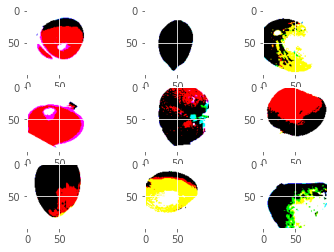

In [ ]:

#-- Images are strange because they are preprocessed by VGG16. 

for i in range(9):
  plt.subplot(330 + 1 + i)
  b,g,r = cv2.split(l[i])       
  rgb_img = cv2.merge([r,g,b])
  plt.imshow(rgb_img)     

In [ ]:
num_classes = len(np.unique(vgg16_pipe.test_generator.labels))
print(f"Numero di classi: {num_classes}")

Numero di classi: 131


###### ***ONLY OUTPUT***

In [ ]:
#-- FINE-TUNING.

# without data augmentation.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 131)               603779    
Total params: 15,318,467
Trainable params: 603,779
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 175s 329ms/step - loss: 13.6751 - categorical_accuracy: 0.2636 - val_loss: 2.2527 - val_categorical_accuracy: 0.7407
Epoch 2/20
529/529 [==============================] - 173s 328ms/step - loss: 0.9314 - categorical_accuracy: 0.8201 - val_loss: 1.3595 - val_categorical_accuracy: 0.8334
Epoch 3/20
529/529 [==============================] - 173s 327ms/step - loss: 0.4173 - categorical_accuracy: 0.9064 - val_loss: 1.0516 - val_categorical_accuracy: 0.8756
Epoch 4/20
529/529 [==============================] - 173s 326ms/step - loss: 0.2496 - categorical_accuracy: 0.9395 - val_loss: 0.8916 - val_categorical_accuracy: 0.8929
Epoch 5/20
529/529 [==============================] - 174s 329ms/step - loss: 0.1710 - categorical_accuracy: 0.9549 - val_loss: 0.7842 - val_categorical_accuracy: 0.9101
Epoch 6/20
529/529 [==============================] - 173s 326ms/step - loss: 0.1257 - categorical_accuracy: 0.9670 - val_loss: 0.6950 - val_categori

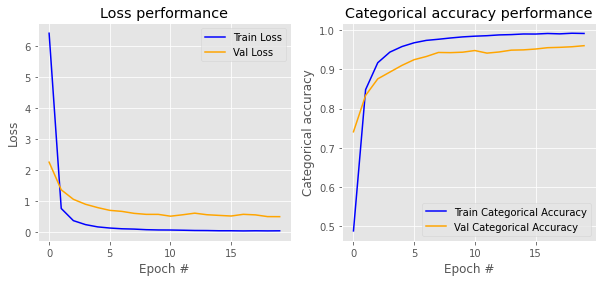

89/89 [==============================] - 11s 122ms/step - loss: 0.5567 - categorical_accuracy: 0.9588
Final accuracy: 0.9587774276733398


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 NEURONS WITHOUT REGULARIZATION***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_2 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 1,213,571
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 166s 313ms/step - loss: 7.2127 - categorical_accuracy: 0.3125 - val_loss: 1.3501 - val_categorical_accuracy: 0.7405
Epoch 2/20
529/529 [==============================] - 173s 327ms/step - loss: 0.5467 - categorical_accuracy: 0.8465 - val_loss: 0.8717 - val_categorical_accuracy: 0.8408
Epoch 3/20
529/529 [==============================] - 169s 319ms/step - loss: 0.2364 - categorical_accuracy: 0.9278 - val_loss: 0.6988 - val_categorical_accuracy: 0.8805
Epoch 4/20
529/529 [==============================] - 164s 310ms/step - loss: 0.1453 - categorical_accuracy: 0.9538 - val_loss: 0.5775 - val_categorical_accuracy: 0.9048
Epoch 5/20
529/529 [==============================] - 168s 317ms/step - loss: 0.0967 - categorical_accuracy: 0.9694 - val_loss: 0.4966 - val_categorical_accuracy: 0.9167
Epoch 6/20
529/529 [==============================] - 168s 317ms/step - loss: 0.0812 - categorical_accuracy: 0.9754 - val_loss: 0.4534 - val_categoric

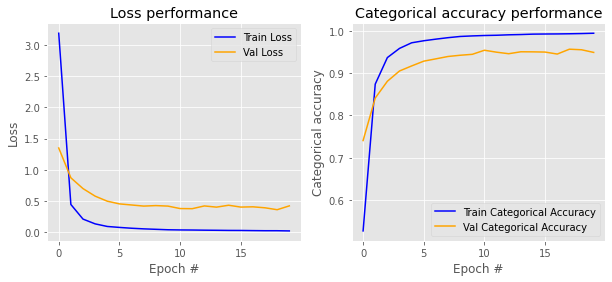

89/89 [==============================] - 8s 88ms/step - loss: 0.4284 - categorical_accuracy: 0.9499
Final accuracy: 0.9498810768127441


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH L1 REGULARIZATION***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_4 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 1,213,571
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 167s 314ms/step - loss: 142.9656 - categorical_accuracy: 0.3195 - val_loss: 24.4642 - val_categorical_accuracy: 0.7596
Epoch 2/20
529/529 [==============================] - 162s 305ms/step - loss: 17.3636 - categorical_accuracy: 0.8448 - val_loss: 6.9318 - val_categorical_accuracy: 0.8150
Epoch 3/20
529/529 [==============================] - 162s 305ms/step - loss: 5.3555 - categorical_accuracy: 0.8881 - val_loss: 3.3331 - val_categorical_accuracy: 0.8311
Epoch 4/20
529/529 [==============================] - 162s 306ms/step - loss: 2.7507 - categorical_accuracy: 0.8968 - val_loss: 2.2767 - val_categorical_accuracy: 0.8325
Epoch 5/20
529/529 [==============================] - 160s 302ms/step - loss: 1.9766 - categorical_accuracy: 0.8993 - val_loss: 1.8556 - val_categorical_accuracy: 0.8491
Epoch 6/20
529/529 [==============================] - 160s 302ms/step - loss: 1.6438 - categorical_accuracy: 0.9092 - val_loss: 1.7465 - val_categ

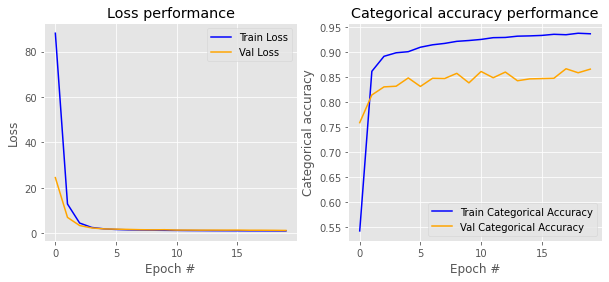

89/89 [==============================] - 8s 87ms/step - loss: 1.1999 - categorical_accuracy: 0.8591
Final accuracy: 0.8590680956840515


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH L2 REGULARIZATION*** 

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 1,213,571
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 219s 344ms/step - loss: 11.5634 - categorical_accuracy: 0.3173 - val_loss: 4.3534 - val_categorical_accuracy: 0.7588
Epoch 2/20
529/529 [==============================] - 175s 330ms/step - loss: 3.3845 - categorical_accuracy: 0.8537 - val_loss: 2.9128 - val_categorical_accuracy: 0.8650
Epoch 3/20
529/529 [==============================] - 175s 330ms/step - loss: 2.2755 - categorical_accuracy: 0.9328 - val_loss: 2.2425 - val_categorical_accuracy: 0.8798
Epoch 4/20
529/529 [==============================] - 174s 329ms/step - loss: 1.6542 - categorical_accuracy: 0.9552 - val_loss: 1.6937 - val_categorical_accuracy: 0.9061
Epoch 5/20
529/529 [==============================] - 174s 329ms/step - loss: 1.2405 - categorical_accuracy: 0.9676 - val_loss: 1.3427 - val_categorical_accuracy: 0.9162
Epoch 6/20
529/529 [==============================] - 175s 331ms/step - loss: 0.9360 - categorical_accuracy: 0.9775 - val_loss: 1.0794 - val_categori

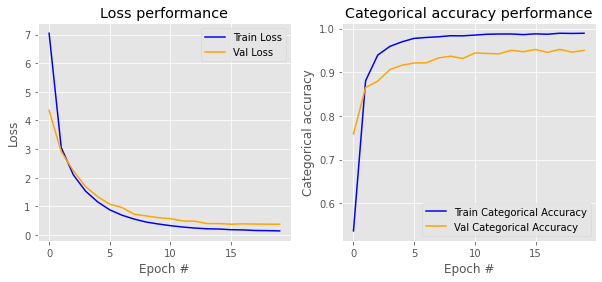

89/89 [==============================] - 15s 163ms/step - loss: 0.3988 - categorical_accuracy: 0.9472
Final accuracy: 0.9472386240959167


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 1,213,571
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 160s 301ms/step - loss: 8.6322 - categorical_accuracy: 0.1998 - val_loss: 1.5177 - val_categorical_accuracy: 0.6714
Epoch 2/20
529/529 [==============================] - 163s 308ms/step - loss: 1.1595 - categorical_accuracy: 0.6996 - val_loss: 0.8846 - val_categorical_accuracy: 0.8036
Epoch 3/20
529/529 [==============================] - 159s 300ms/step - loss: 0.5634 - categorical_accuracy: 0.8401 - val_loss: 0.6715 - val_categorical_accuracy: 0.8561
Epoch 4/20
529/529 [==============================] - 159s 300ms/step - loss: 0.3591 - categorical_accuracy: 0.8941 - val_loss: 0.5646 - val_categorical_accuracy: 0.8788
Epoch 5/20
529/529 [==============================] - 160s 302ms/step - loss: 0.2628 - categorical_accuracy: 0.9201 - val_loss: 0.4472 - val_categorical_accuracy: 0.9048
Epoch 6/20
529/529 [==============================] - 159s 300ms/step - loss: 0.1910 - categorical_accuracy: 0.9418 - val_loss: 0.4335 - val_categoric

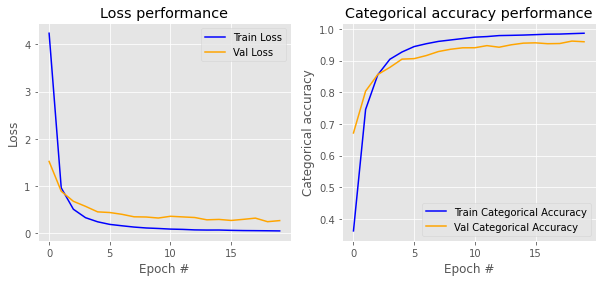

89/89 [==============================] - 8s 93ms/step - loss: 0.3010 - categorical_accuracy: 0.9586
Final accuracy: 0.9586012363433838


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+128 WITHOUT REGULARIZATION***

In [ ]:
#-- VGG16: +128 + no regularization.
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu',  kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_8 (Dense)              (None, 131)               16899     
Total params: 15,321,539
Trainable params: 606,851
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 178s 335ms/step - loss: 7.1175 - categorical_accuracy: 0.1540 - val_loss: 1.8197 - val_categorical_accuracy: 0.5683
Epoch 2/20
529/529 [==============================] - 174s 330ms/step - loss: 1.1024 - categorical_accuracy: 0.7110 - val_loss: 0.8888 - val_categorical_accuracy: 0.7965
Epoch 3/20
529/529 [==============================] - 174s 329ms/step - loss: 0.3821 - categorical_accuracy: 0.8872 - val_loss: 0.6234 - val_categorical_accuracy: 0.8627
Epoch 4/20
529/529 [==============================] - 174s 329ms/step - loss: 0.2156 - categorical_accuracy: 0.9327 - val_loss: 0.5323 - val_categorical_accuracy: 0.8865
Epoch 5/20
529/529 [==============================] - 174s 328ms/step - loss: 0.1399 - categorical_accuracy: 0.9571 - val_loss: 0.4623 - val_categorical_accuracy: 0.9070
Epoch 6/20
529/529 [==============================] - 173s 328ms/step - loss: 0.1028 - categorical_accuracy: 0.9665 - val_loss: 0.4044 - val_categoric

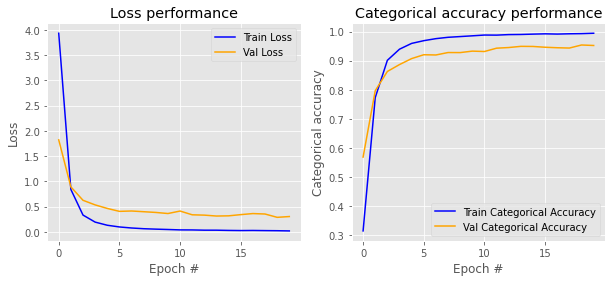

89/89 [==============================] - 11s 122ms/step - loss: 0.3186 - categorical_accuracy: 0.9494
Final accuracy: 0.9494406580924988


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+128 WITH REGULARIZATION  L2***

In [ ]:
#-- VGG16: +128 + regularization l2.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 131)               16899     
Total params: 15,321,539
Trainable params: 606,851
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 173s 326ms/step - loss: 9.3312 - categorical_accuracy: 0.1458 - val_loss: 3.6573 - val_categorical_accuracy: 0.5577
Epoch 2/20
529/529 [==============================] - 172s 326ms/step - loss: 2.7321 - categorical_accuracy: 0.6867 - val_loss: 2.1158 - val_categorical_accuracy: 0.7893
Epoch 3/20
529/529 [==============================] - 172s 325ms/step - loss: 1.4857 - categorical_accuracy: 0.8868 - val_loss: 1.5254 - val_categorical_accuracy: 0.8541
Epoch 4/20
529/529 [==============================] - 173s 326ms/step - loss: 1.0540 - categorical_accuracy: 0.9346 - val_loss: 1.1581 - val_categorical_accuracy: 0.8855
Epoch 5/20
529/529 [==============================] - 172s 325ms/step - loss: 0.7850 - categorical_accuracy: 0.9586 - val_loss: 0.9475 - val_categorical_accuracy: 0.9078
Epoch 6/20
529/529 [==============================] - 173s 328ms/step - loss: 0.6120 - categorical_accuracy: 0.9682 - val_loss: 0.7794 - val_categoric

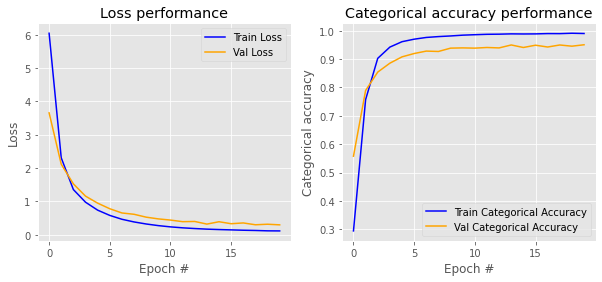

89/89 [==============================] - 11s 122ms/step - loss: 0.3280 - categorical_accuracy: 0.9466
Final accuracy: 0.9466220140457153


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512 WITHOUT REGULARIZATION***

In [ ]:
#-- VGG16: +512 + without regularization.
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 131)               67203     
Total params: 17,141,699
Trainable params: 2,427,011
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 216s 339ms/step - loss: 6.5227 - categorical_accuracy: 0.4585 - val_loss: 1.0723 - val_categorical_accuracy: 0.8218
Epoch 2/20
529/529 [==============================] - 172s 324ms/step - loss: 0.3412 - categorical_accuracy: 0.9088 - val_loss: 0.6924 - val_categorical_accuracy: 0.8819
Epoch 3/20
529/529 [==============================] - 172s 325ms/step - loss: 0.1750 - categorical_accuracy: 0.9513 - val_loss: 0.6431 - val_categorical_accuracy: 0.9007
Epoch 4/20
529/529 [==============================] - 172s 325ms/step - loss: 0.1213 - categorical_accuracy: 0.9649 - val_loss: 0.5044 - val_categorical_accuracy: 0.9195
Epoch 5/20
529/529 [==============================] - 173s 327ms/step - loss: 0.0947 - categorical_accuracy: 0.9737 - val_loss: 0.4935 - val_categorical_accuracy: 0.9264
Epoch 6/20
529/529 [==============================] - 172s 325ms/step - loss: 0.0640 - categorical_accuracy: 0.9810 - val_loss: 0.4277 - val_categoric

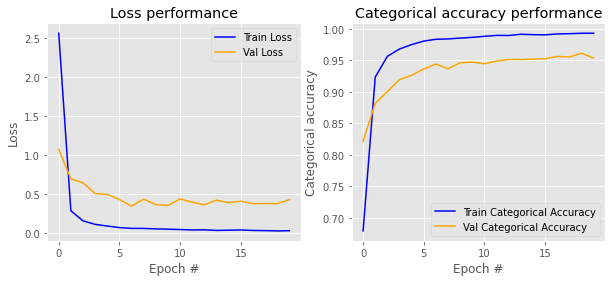

89/89 [==============================] - 15s 163ms/step - loss: 0.4539 - categorical_accuracy: 0.9540
Final accuracy: 0.9540209770202637


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512 WITH REGULARIZATION L2***

In [ ]:
#-- VGG16: +512 + regularization l2.
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_5 (Dense)              (None, 131)               67203     
Total params: 17,141,699
Trainable params: 2,427,011
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 171s 322ms/step - loss: 14.1656 - categorical_accuracy: 0.4664 - val_loss: 6.7973 - val_categorical_accuracy: 0.8199
Epoch 2/20
529/529 [==============================] - 170s 322ms/step - loss: 5.4016 - categorical_accuracy: 0.9076 - val_loss: 4.6325 - val_categorical_accuracy: 0.8690
Epoch 3/20
529/529 [==============================] - 171s 324ms/step - loss: 3.6346 - categorical_accuracy: 0.9521 - val_loss: 3.3856 - val_categorical_accuracy: 0.8910
Epoch 4/20
529/529 [==============================] - 170s 322ms/step - loss: 2.5850 - categorical_accuracy: 0.9665 - val_loss: 2.5055 - val_categorical_accuracy: 0.9154
Epoch 5/20
529/529 [==============================] - 172s 325ms/step - loss: 1.8938 - categorical_accuracy: 0.9728 - val_loss: 1.9251 - val_categorical_accuracy: 0.9278
Epoch 6/20
529/529 [==============================] - 171s 323ms/step - loss: 1.4253 - categorical_accuracy: 0.9774 - val_loss: 1.6403 - val_categori

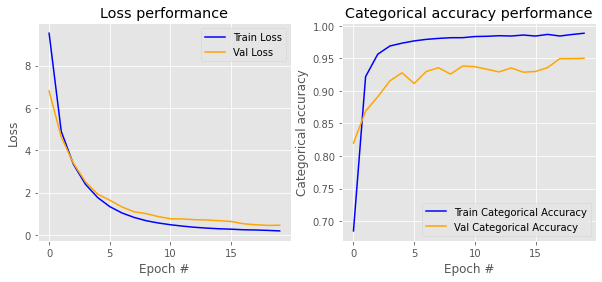

89/89 [==============================] - 11s 122ms/step - loss: 0.4611 - categorical_accuracy: 0.9509
Final accuracy: 0.9508500099182129


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512+256 WITHOUT REGULARIZATION***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 131)               33667     
Total params: 17,239,491
Trainable params: 2,524,803
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 161s 303ms/step - loss: 4.6934 - categorical_accuracy: 0.3994 - val_loss: 0.9054 - val_categorical_accuracy: 0.7984
Epoch 2/20
529/529 [==============================] - 158s 299ms/step - loss: 0.2940 - categorical_accuracy: 0.9088 - val_loss: 0.5688 - val_categorical_accuracy: 0.8821
Epoch 3/20
529/529 [==============================] - 159s 300ms/step - loss: 0.1357 - categorical_accuracy: 0.9577 - val_loss: 0.4156 - val_categorical_accuracy: 0.9076
Epoch 4/20
529/529 [==============================] - 159s 300ms/step - loss: 0.0912 - categorical_accuracy: 0.9710 - val_loss: 0.3670 - val_categorical_accuracy: 0.9214
Epoch 5/20
529/529 [==============================] - 160s 302ms/step - loss: 0.0672 - categorical_accuracy: 0.9782 - val_loss: 0.3559 - val_categorical_accuracy: 0.9255
Epoch 6/20
529/529 [==============================] - 159s 301ms/step - loss: 0.0509 - categorical_accuracy: 0.9829 - val_loss: 0.3415 - val_categoric

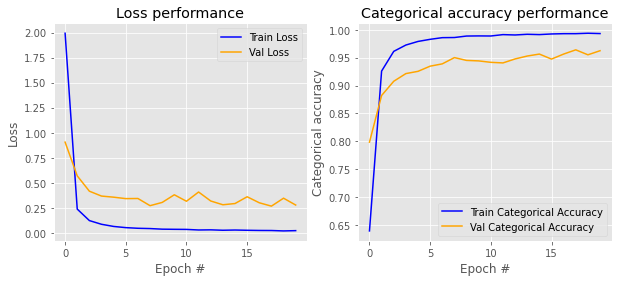

89/89 [==============================] - 8s 92ms/step - loss: 0.3002 - categorical_accuracy: 0.9632
Final accuracy: 0.9631815552711487


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512+256 WITH DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 131)               33667     
Total params: 17,239,491
Trainable params: 2,524,803
Non-trainable params: 14,714,688
__________________________________

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 175s 330ms/step - loss: 6.3342 - categorical_accuracy: 0.2625 - val_loss: 0.8561 - val_categorical_accuracy: 0.7881
Epoch 2/20
529/529 [==============================] - 173s 327ms/step - loss: 0.6534 - categorical_accuracy: 0.8127 - val_loss: 0.5007 - val_categorical_accuracy: 0.8854
Epoch 3/20
529/529 [==============================] - 172s 325ms/step - loss: 0.3105 - categorical_accuracy: 0.9050 - val_loss: 0.4423 - val_categorical_accuracy: 0.9135
Epoch 4/20
529/529 [==============================] - 173s 327ms/step - loss: 0.1997 - categorical_accuracy: 0.9368 - val_loss: 0.3621 - val_categorical_accuracy: 0.9260
Epoch 5/20
529/529 [==============================] - 172s 326ms/step - loss: 0.1452 - categorical_accuracy: 0.9550 - val_loss: 0.3220 - val_categorical_accuracy: 0.9382
Epoch 6/20
529/529 [==============================] - 172s 325ms/step - loss: 0.1173 - categorical_accuracy: 0.9614 - val_loss: 0.3528 - val_categoric

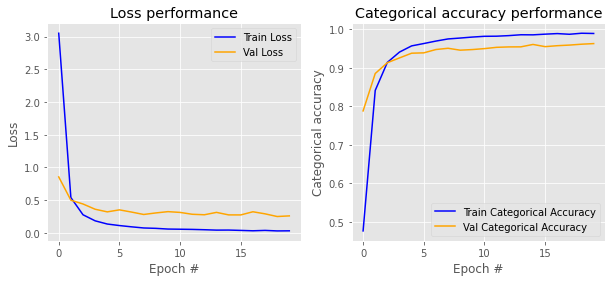

89/89 [==============================] - 11s 122ms/step - loss: 0.2981 - categorical_accuracy: 0.9639
Final accuracy: 0.9638862013816833


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+1024+512+256 WITHOUT DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 131)               33667     
Total params: 20,124,099
Trainable params: 5,409,411
Non-trainable params: 14,714,688
__________________________________

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 160s 301ms/step - loss: 3.0766 - categorical_accuracy: 0.5077 - val_loss: 0.5205 - val_categorical_accuracy: 0.8877
Epoch 2/20
529/529 [==============================] - 159s 300ms/step - loss: 0.1683 - categorical_accuracy: 0.9457 - val_loss: 0.3814 - val_categorical_accuracy: 0.9195
Epoch 3/20
529/529 [==============================] - 159s 300ms/step - loss: 0.1009 - categorical_accuracy: 0.9681 - val_loss: 0.3793 - val_categorical_accuracy: 0.9289
Epoch 4/20
529/529 [==============================] - 159s 300ms/step - loss: 0.0648 - categorical_accuracy: 0.9790 - val_loss: 0.3565 - val_categorical_accuracy: 0.9344
Epoch 5/20
529/529 [==============================] - 159s 300ms/step - loss: 0.0572 - categorical_accuracy: 0.9820 - val_loss: 0.3683 - val_categorical_accuracy: 0.9315
Epoch 6/20
529/529 [==============================] - 159s 301ms/step - loss: 0.0519 - categorical_accuracy: 0.9843 - val_loss: 0.2816 - val_categoric

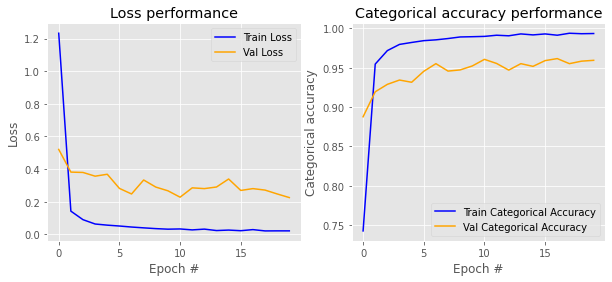

89/89 [==============================] - 8s 94ms/step - loss: 0.2285 - categorical_accuracy: 0.9614
Final accuracy: 0.9614198803901672


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+1024+512+256 WITH DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)              

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 172s 324ms/step - loss: 5.1118 - categorical_accuracy: 0.2576 - val_loss: 0.7714 - val_categorical_accuracy: 0.8041
Epoch 2/20
529/529 [==============================] - 171s 322ms/step - loss: 0.6486 - categorical_accuracy: 0.8103 - val_loss: 0.4450 - val_categorical_accuracy: 0.8918
Epoch 3/20
529/529 [==============================] - 171s 324ms/step - loss: 0.3216 - categorical_accuracy: 0.8997 - val_loss: 0.4142 - val_categorical_accuracy: 0.9090
Epoch 4/20
529/529 [==============================] - 172s 325ms/step - loss: 0.2038 - categorical_accuracy: 0.9341 - val_loss: 0.3664 - val_categorical_accuracy: 0.9194
Epoch 5/20
529/529 [==============================] - 171s 323ms/step - loss: 0.1541 - categorical_accuracy: 0.9514 - val_loss: 0.2890 - val_categorical_accuracy: 0.9378
Epoch 6/20
529/529 [==============================] - 170s 322ms/step - loss: 0.1192 - categorical_accuracy: 0.9625 - val_loss: 0.3018 - val_categoric

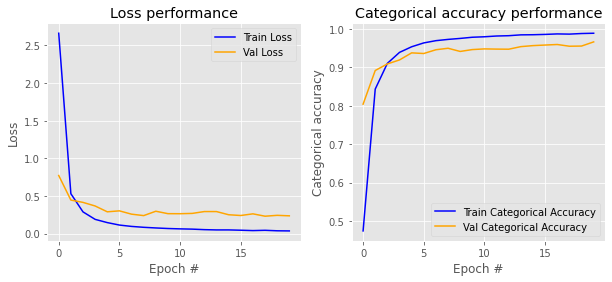

89/89 [==============================] - 11s 123ms/step - loss: 0.2622 - categorical_accuracy: 0.9618
Final accuracy: 0.9617722034454346


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***2056+1024+512+256 WITH DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(2056, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 2056)              9476104   
_________________________________________________________________
dropout (Dropout)            (None, 2056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2106368   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 180s 306ms/step - loss: 4.1724 - categorical_accuracy: 0.2895 - val_loss: 0.6566 - val_categorical_accuracy: 0.8258
Epoch 2/20
529/529 [==============================] - 161s 304ms/step - loss: 0.5353 - categorical_accuracy: 0.8394 - val_loss: 0.4189 - val_categorical_accuracy: 0.8860
Epoch 3/20
529/529 [==============================] - 157s 297ms/step - loss: 0.2681 - categorical_accuracy: 0.9143 - val_loss: 0.3458 - val_categorical_accuracy: 0.9151
Epoch 4/20
529/529 [==============================] - 156s 295ms/step - loss: 0.1774 - categorical_accuracy: 0.9424 - val_loss: 0.3356 - val_categorical_accuracy: 0.9215
Epoch 5/20
529/529 [==============================] - 157s 297ms/step - loss: 0.1419 - categorical_accuracy: 0.9550 - val_loss: 0.2982 - val_categorical_accuracy: 0.9307
Epoch 6/20
529/529 [==============================] - 157s 296ms/step - loss: 0.1060 - categorical_accuracy: 0.9653 - val_loss: 0.2835 - val_categoric

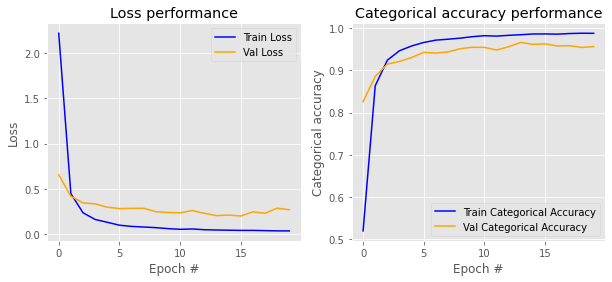

89/89 [==============================] - 9s 100ms/step - loss: 0.2826 - categorical_accuracy: 0.9554
Final accuracy: 0.955430269241333


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

#### ***FINE TUNING FROM block5_conv1 TRIALS***
---

2. _Retrain the `Conv5-1`, `Conv5-2`, `Conv5-3` with our data and drop the last dense layers and add one or more dense layers trained with our data as sketched in the image below_. <br>
We want to try also this approach because  high-level features extract from our dataset can lead to more accurate features for our task than the ones of imagenet which don't focus on fruits images. We have ~70000 training data that is a sufficient number of samples in order to train the last part of the model.

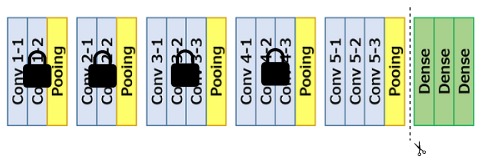

In [ ]:
#-- BASE MODEL.

conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f"Layer {layer.name}, trainable? {layer.trainable}")

58892288/58889256 [==============================] - 0s 0us/step
Layer input_1, trainable? False
Layer block1_conv1, trainable? False
Layer block1_conv2, trainable? False
Layer block1_pool, trainable? False
Layer block2_conv1, trainable? False
Layer block2_conv2, trainable? False
Layer block2_pool, trainable? False
Layer block3_conv1, trainable? False
Layer block3_conv2, trainable? False
Layer block3_conv3, trainable? False
Layer block3_pool, trainable? False
Layer block4_conv1, trainable? False
Layer block4_conv2, trainable? False
Layer block4_conv3, trainable? False
Layer block4_pool, trainable? False
Layer block5_conv1, trainable? True
Layer block5_conv2, trainable? True
Layer block5_conv3, trainable? True
Layer block5_pool, trainable? True


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
# Define object.
vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, LEARNING_RATE, RANDOM_STATE)

##### __WITHOUT DATA AUGMENTATION__

In [ ]:
# Split dataset.
vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 0)

Without data augmentation
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


###### ***ONLY OUTPUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131)               603779    
Total params: 15,318,467
Trainable params: 7,683,203
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 127s 170ms/step - loss: 2.7724 - categorical_accuracy: 0.5978 - val_loss: 0.2555 - val_categorical_accuracy: 0.9499
Epoch 2/20
529/529 [==============================] - 88s 167ms/step - loss: 8.6595e-04 - categorical_accuracy: 0.9999 - val_loss: 0.2149 - val_categorical_accuracy: 0.9582
Epoch 3/20
529/529 [==============================] - 88s 167ms/step - loss: 1.0724e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2049 - val_categorical_accuracy: 0.9636
Epoch 4/20
529/529 [==============================] - 89s 167ms/step - loss: 3.4088e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2018 - val_categorical_accuracy: 0.9644
Epoch 5/20
529/529 [==============================] - 89s 167ms/step - loss: 1.3907e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1947 - val_categorical_accuracy: 0.9660
Epoch 6/20
529/529 [==============================] - 89s 167ms/step - loss: 6.4884e-06 - categorical_accuracy: 1.0000 - val_loss: 0.1926 

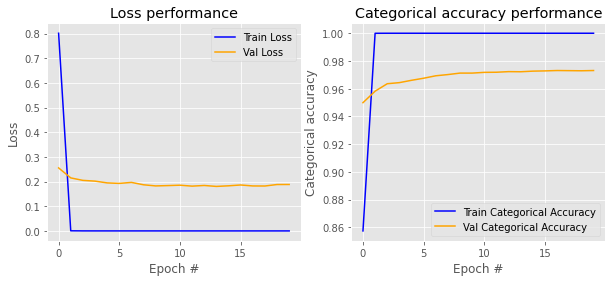

89/89 [==============================] - 15s 166ms/step - loss: 0.2170 - categorical_accuracy: 0.9697
Final accuracy: 0.9696996212005615


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITHOUT REGULARIZATION***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_6 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 8,292,995
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 60s 113ms/step - loss: 2.9669 - categorical_accuracy: 0.4786 - val_loss: 0.3161 - val_categorical_accuracy: 0.9320
Epoch 2/20
529/529 [==============================] - 59s 112ms/step - loss: 0.0066 - categorical_accuracy: 0.9986 - val_loss: 0.6001 - val_categorical_accuracy: 0.8904
Epoch 3/20
529/529 [==============================] - 60s 113ms/step - loss: 0.0345 - categorical_accuracy: 0.9909 - val_loss: 0.1325 - val_categorical_accuracy: 0.9759
Epoch 4/20
529/529 [==============================] - 59s 112ms/step - loss: 9.1489e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1233 - val_categorical_accuracy: 0.9779
Epoch 5/20
529/529 [==============================] - 60s 112ms/step - loss: 3.1468e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1270 - val_categorical_accuracy: 0.9801
Epoch 6/20
529/529 [==============================] - 60s 113ms/step - loss: 1.4456e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1294 - val_cat

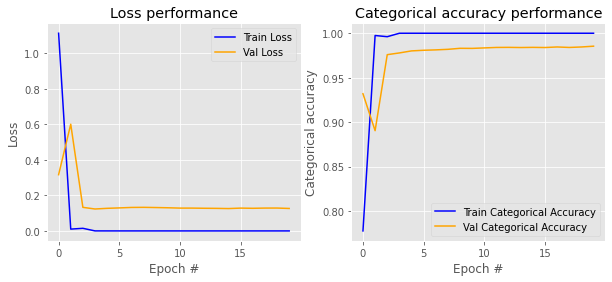

89/89 [==============================] - 8s 92ms/step - loss: 0.1856 - categorical_accuracy: 0.9834
Final accuracy: 0.9833524227142334


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH REGULARIZATION L2***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer = l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_10 (Dense)             (None, 131)               33667     
Total params: 15,928,259
Trainable params: 8,292,995
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 61s 113ms/step - loss: 6.1625 - categorical_accuracy: 0.5701 - val_loss: 1.4815 - val_categorical_accuracy: 0.9575
Epoch 2/20
529/529 [==============================] - 60s 113ms/step - loss: 1.0896 - categorical_accuracy: 1.0000 - val_loss: 0.8104 - val_categorical_accuracy: 0.9669
Epoch 3/20
529/529 [==============================] - 60s 113ms/step - loss: 0.5740 - categorical_accuracy: 1.0000 - val_loss: 0.5284 - val_categorical_accuracy: 0.9675
Epoch 4/20
529/529 [==============================] - 60s 112ms/step - loss: 0.3485 - categorical_accuracy: 0.9973 - val_loss: 0.3956 - val_categorical_accuracy: 0.9667
Epoch 5/20
529/529 [==============================] - 60s 113ms/step - loss: 0.2290 - categorical_accuracy: 0.9997 - val_loss: 0.2417 - val_categorical_accuracy: 0.9820
Epoch 6/20
529/529 [==============================] - 60s 113ms/step - loss: 0.1524 - categorical_accuracy: 1.0000 - val_loss: 0.1871 - val_categorical_acc

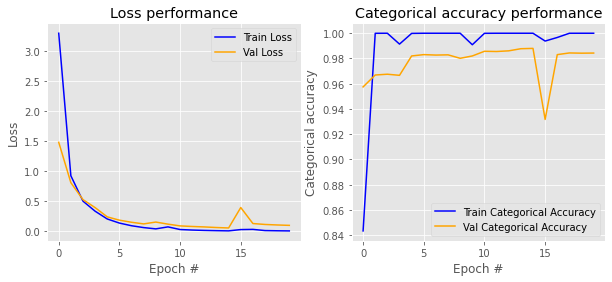

89/89 [==============================] - 8s 92ms/step - loss: 0.1262 - categorical_accuracy: 0.9799
Final accuracy: 0.9799172282218933


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH DROPOUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 131)               33667     
Total params: 15,928,259
Trainable params: 8,292,995
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 60s 113ms/step - loss: 5.1142 - categorical_accuracy: 0.3081 - val_loss: 0.1313 - val_categorical_accuracy: 0.9667
Epoch 2/20
529/529 [==============================] - 59s 112ms/step - loss: 0.0170 - categorical_accuracy: 0.9957 - val_loss: 0.2036 - val_categorical_accuracy: 0.9602
Epoch 3/20
529/529 [==============================] - 59s 112ms/step - loss: 0.0051 - categorical_accuracy: 0.9987 - val_loss: 0.1709 - val_categorical_accuracy: 0.9671
Epoch 4/20
529/529 [==============================] - 59s 112ms/step - loss: 0.0108 - categorical_accuracy: 0.9974 - val_loss: 0.2339 - val_categorical_accuracy: 0.9580
Epoch 5/20
529/529 [==============================] - 59s 112ms/step - loss: 0.0093 - categorical_accuracy: 0.9972 - val_loss: 0.1606 - val_categorical_accuracy: 0.9763
Epoch 6/20
529/529 [==============================] - 59s 112ms/step - loss: 0.0043 - categorical_accuracy: 0.9988 - val_loss: 0.1475 - val_categorical_acc

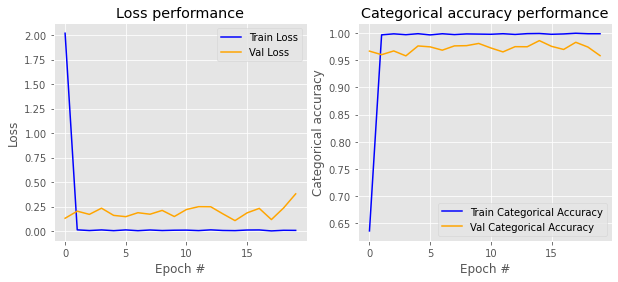

89/89 [==============================] - 8s 92ms/step - loss: 0.3930 - categorical_accuracy: 0.9590
Final accuracy: 0.9590416550636292


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512 WITHOUT REGULARIZATION***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 131)               67203     
Total params: 17,141,699
Trainable params: 9,506,435
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 87s 162ms/step - loss: 3.3195 - categorical_accuracy: 0.3892 - val_loss: 0.2369 - val_categorical_accuracy: 0.9516
Epoch 2/20
529/529 [==============================] - 89s 167ms/step - loss: 0.0093 - categorical_accuracy: 0.9980 - val_loss: 0.2563 - val_categorical_accuracy: 0.9440
Epoch 3/20
529/529 [==============================] - 88s 167ms/step - loss: 0.0055 - categorical_accuracy: 0.9983 - val_loss: 0.1678 - val_categorical_accuracy: 0.9695
Epoch 4/20
529/529 [==============================] - 89s 168ms/step - loss: 7.7247e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1629 - val_categorical_accuracy: 0.9700
Epoch 5/20
529/529 [==============================] - 89s 168ms/step - loss: 3.9794e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1594 - val_categorical_accuracy: 0.9712
Epoch 6/20
529/529 [==============================] - 88s 167ms/step - loss: 2.0846e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1700 - val_cat

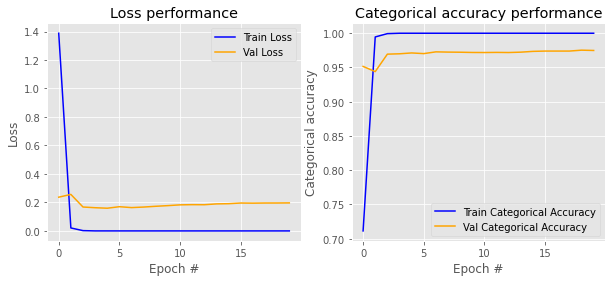

89/89 [==============================] - 11s 124ms/step - loss: 0.2468 - categorical_accuracy: 0.9738
Final accuracy: 0.973839521408081


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512 WITH REGULARIZATION  L2***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_8 (Dense)              (None, 131)               67203     
Total params: 17,141,699
Trainable params: 9,506,435
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 60s 113ms/step - loss: 8.0560 - categorical_accuracy: 0.4500 - val_loss: 0.6768 - val_categorical_accuracy: 0.9479
Epoch 2/20
529/529 [==============================] - 59s 112ms/step - loss: 0.3847 - categorical_accuracy: 0.9975 - val_loss: 0.4927 - val_categorical_accuracy: 0.9571
Epoch 3/20
529/529 [==============================] - 59s 112ms/step - loss: 0.2647 - categorical_accuracy: 0.9980 - val_loss: 0.3511 - val_categorical_accuracy: 0.9696
Epoch 4/20
529/529 [==============================] - 59s 112ms/step - loss: 0.1875 - categorical_accuracy: 0.9998 - val_loss: 0.2706 - val_categorical_accuracy: 0.9769
Epoch 5/20
529/529 [==============================] - 59s 112ms/step - loss: 0.1370 - categorical_accuracy: 1.0000 - val_loss: 0.2317 - val_categorical_accuracy: 0.9769
Epoch 6/20
529/529 [==============================] - 59s 112ms/step - loss: 0.1002 - categorical_accuracy: 1.0000 - val_loss: 0.2013 - val_categorical_acc

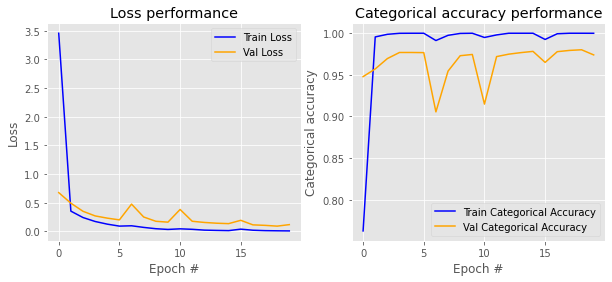

89/89 [==============================] - 8s 91ms/step - loss: 0.1275 - categorical_accuracy: 0.9733
Final accuracy: 0.9733110070228577


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512+256 WITHOUT  DROPOUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 131)               33667     
Total params: 17,239,491
Trainable params: 9,604,227
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 60s 113ms/step - loss: 1.7214 - categorical_accuracy: 0.8013 - val_loss: 0.1481 - val_categorical_accuracy: 0.9724
Epoch 2/20
529/529 [==============================] - 60s 113ms/step - loss: 3.1979e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1409 - val_categorical_accuracy: 0.9764
Epoch 3/20
529/529 [==============================] - 60s 112ms/step - loss: 1.7850e-06 - categorical_accuracy: 1.0000 - val_loss: 0.1455 - val_categorical_accuracy: 0.9773
Epoch 4/20
529/529 [==============================] - 60s 113ms/step - loss: 5.0954e-07 - categorical_accuracy: 1.0000 - val_loss: 0.1492 - val_categorical_accuracy: 0.9788
Epoch 5/20
529/529 [==============================] - 59s 112ms/step - loss: 2.1828e-07 - categorical_accuracy: 1.0000 - val_loss: 0.1515 - val_categorical_accuracy: 0.9790
Epoch 6/20
529/529 [==============================] - 59s 112ms/step - loss: 1.1562e-07 - categorical_accuracy: 1.0000 - val_loss: 0.1516 -

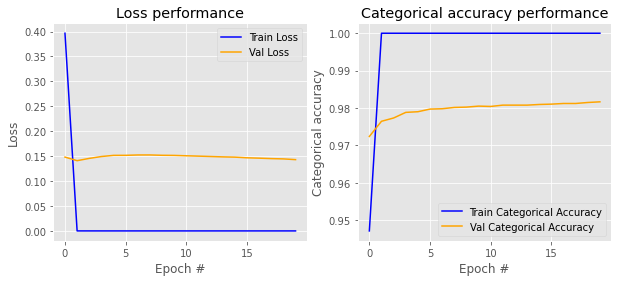

89/89 [==============================] - 8s 92ms/step - loss: 0.1415 - categorical_accuracy: 0.9797
Final accuracy: 0.9796529412269592


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512+256 WITH REGULARIZATION  DROPOUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 131)               33667     
Total params: 17,239,491
Trainable params: 9,604,227
Non-trainable params: 7,635,264
___________________________________

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 89s 166ms/step - loss: 4.8627 - categorical_accuracy: 0.1039 - val_loss: 1.4972 - val_categorical_accuracy: 0.6147
Epoch 2/20
529/529 [==============================] - 89s 168ms/step - loss: 0.9053 - categorical_accuracy: 0.7589 - val_loss: 0.2567 - val_categorical_accuracy: 0.9438
Epoch 3/20
529/529 [==============================] - 89s 167ms/step - loss: 0.0249 - categorical_accuracy: 0.9932 - val_loss: 0.2123 - val_categorical_accuracy: 0.9606
Epoch 4/20
529/529 [==============================] - 88s 167ms/step - loss: 0.0092 - categorical_accuracy: 0.9973 - val_loss: 0.1980 - val_categorical_accuracy: 0.9655
Epoch 5/20
529/529 [==============================] - 88s 167ms/step - loss: 0.0084 - categorical_accuracy: 0.9978 - val_loss: 0.3334 - val_categorical_accuracy: 0.9244
Epoch 6/20
529/529 [==============================] - 88s 167ms/step - loss: 0.0295 - categorical_accuracy: 0.9920 - val_loss: 0.1804 - val_categorical_acc

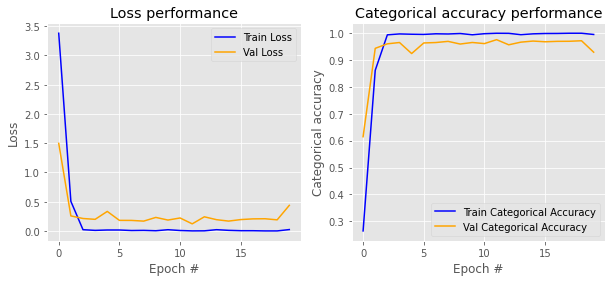

89/89 [==============================] - 11s 125ms/step - loss: 0.5064 - categorical_accuracy: 0.9222
Final accuracy: 0.9222232103347778


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+1024+512+256 WITHOUT DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 131)               33667     
Total params: 20,124,099
Trainable params: 12,488,835
Non-trainable params: 7,635,264
__________________________________

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 91s 171ms/step - loss: 1.7913 - categorical_accuracy: 0.7192 - val_loss: 0.1636 - val_categorical_accuracy: 0.9708
Epoch 2/20
529/529 [==============================] - 90s 169ms/step - loss: 6.4332e-05 - categorical_accuracy: 1.0000 - val_loss: 0.1380 - val_categorical_accuracy: 0.9742
Epoch 3/20
529/529 [==============================] - 89s 169ms/step - loss: 2.4081e-06 - categorical_accuracy: 1.0000 - val_loss: 0.1332 - val_categorical_accuracy: 0.9743
Epoch 4/20
529/529 [==============================] - 89s 169ms/step - loss: 4.6784e-07 - categorical_accuracy: 1.0000 - val_loss: 0.1376 - val_categorical_accuracy: 0.9744
Epoch 5/20
529/529 [==============================] - 89s 169ms/step - loss: 1.9143e-07 - categorical_accuracy: 1.0000 - val_loss: 0.1390 - val_categorical_accuracy: 0.9744
Epoch 6/20
529/529 [==============================] - 89s 169ms/step - loss: 1.0330e-07 - categorical_accuracy: 1.0000 - val_loss: 0.1403 -

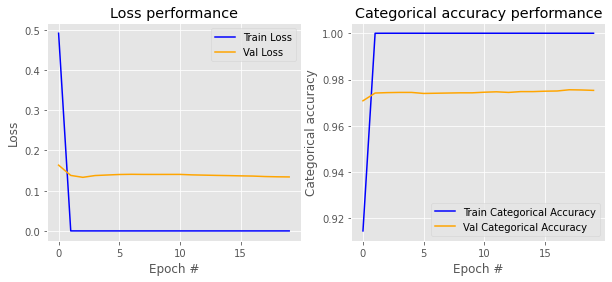

89/89 [==============================] - 11s 124ms/step - loss: 0.1557 - categorical_accuracy: 0.9762
Final accuracy: 0.9762177467346191


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+1024+512+256 WITH DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              4719616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)              

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 91s 170ms/step - loss: 2.6962 - categorical_accuracy: 0.6169 - val_loss: 0.1588 - val_categorical_accuracy: 0.9708
Epoch 2/20
529/529 [==============================] - 89s 169ms/step - loss: 0.0068 - categorical_accuracy: 0.9982 - val_loss: 0.1209 - val_categorical_accuracy: 0.9776
Epoch 3/20
529/529 [==============================] - 89s 169ms/step - loss: 0.0071 - categorical_accuracy: 0.9982 - val_loss: 0.1334 - val_categorical_accuracy: 0.9745
Epoch 4/20
529/529 [==============================] - 89s 169ms/step - loss: 0.0089 - categorical_accuracy: 0.9981 - val_loss: 0.1685 - val_categorical_accuracy: 0.9704
Epoch 5/20
529/529 [==============================] - 90s 169ms/step - loss: 0.0113 - categorical_accuracy: 0.9973 - val_loss: 0.1186 - val_categorical_accuracy: 0.9773
Epoch 6/20
529/529 [==============================] - 90s 169ms/step - loss: 0.0065 - categorical_accuracy: 0.9990 - val_loss: 0.1279 - val_categorical_acc

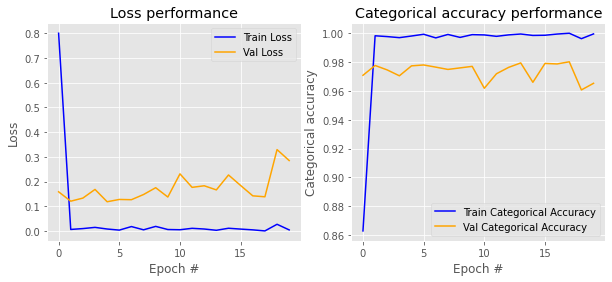

89/89 [==============================] - 11s 124ms/step - loss: 0.3178 - categorical_accuracy: 0.9611
Final accuracy: 0.9610675573348999


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

##### __WITH DATA AUGMENTATION__

In [ ]:
# Split dataset.
vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


###### ***ONLY OUTPUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 131)               603779    
Total params: 15,318,467
Trainable params: 7,683,203
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 192s 330ms/step - loss: 3.8811 - categorical_accuracy: 0.3167 - val_loss: 0.4406 - val_categorical_accuracy: 0.8771
Epoch 2/20
529/529 [==============================] - 171s 323ms/step - loss: 0.1335 - categorical_accuracy: 0.9570 - val_loss: 0.3102 - val_categorical_accuracy: 0.9360
Epoch 3/20
529/529 [==============================] - 171s 323ms/step - loss: 0.0575 - categorical_accuracy: 0.9814 - val_loss: 0.2117 - val_categorical_accuracy: 0.9490
Epoch 4/20
529/529 [==============================] - 172s 324ms/step - loss: 0.0383 - categorical_accuracy: 0.9875 - val_loss: 0.2576 - val_categorical_accuracy: 0.9485
Epoch 5/20
529/529 [==============================] - 172s 325ms/step - loss: 0.0320 - categorical_accuracy: 0.9899 - val_loss: 0.2727 - val_categorical_accuracy: 0.9499
Epoch 6/20
529/529 [==============================] - 173s 327ms/step - loss: 0.0313 - categorical_accuracy: 0.9893 - val_loss: 0.2215 - val_categoric

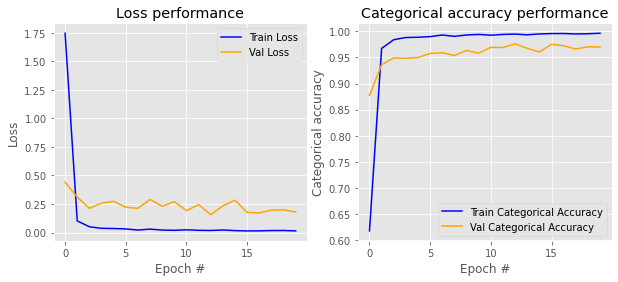

89/89 [==============================] - 10s 113ms/step - loss: 0.1834 - categorical_accuracy: 0.9693
Final accuracy: 0.9692592024803162


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITHOUT REGULARIZATION***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_2 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 8,292,995
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 172s 325ms/step - loss: 2.9728 - categorical_accuracy: 0.5472 - val_loss: 0.2468 - val_categorical_accuracy: 0.9605
Epoch 2/20
529/529 [==============================] - 169s 319ms/step - loss: 0.0267 - categorical_accuracy: 0.9929 - val_loss: 0.2006 - val_categorical_accuracy: 0.9672
Epoch 3/20
529/529 [==============================] - 170s 321ms/step - loss: 0.0249 - categorical_accuracy: 0.9936 - val_loss: 0.1840 - val_categorical_accuracy: 0.9693
Epoch 4/20
529/529 [==============================] - 169s 319ms/step - loss: 0.0257 - categorical_accuracy: 0.9937 - val_loss: 0.2823 - val_categorical_accuracy: 0.9599
Epoch 5/20
529/529 [==============================] - 170s 322ms/step - loss: 0.0222 - categorical_accuracy: 0.9947 - val_loss: 0.1835 - val_categorical_accuracy: 0.9661
Epoch 6/20
529/529 [==============================] - 171s 322ms/step - loss: 0.0158 - categorical_accuracy: 0.9964 - val_loss: 0.2417 - val_categoric

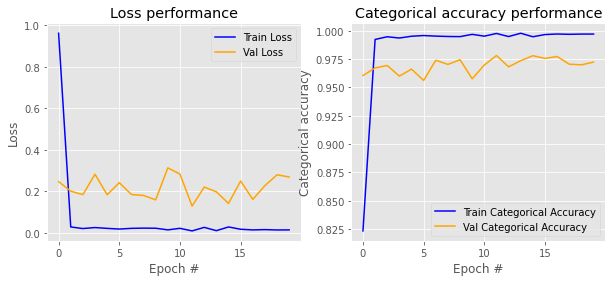

89/89 [==============================] - 8s 94ms/step - loss: 0.3103 - categorical_accuracy: 0.9726
Final accuracy: 0.972606360912323


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH REGULARIZATION L2***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer = l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_4 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 8,292,995
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 173s 326ms/step - loss: 5.7518 - categorical_accuracy: 0.6658 - val_loss: 1.4588 - val_categorical_accuracy: 0.9634
Epoch 2/20
529/529 [==============================] - 170s 322ms/step - loss: 1.0664 - categorical_accuracy: 0.9982 - val_loss: 0.9095 - val_categorical_accuracy: 0.9700
Epoch 3/20
529/529 [==============================] - 170s 322ms/step - loss: 0.6355 - categorical_accuracy: 0.9965 - val_loss: 0.6287 - val_categorical_accuracy: 0.9736
Epoch 4/20
529/529 [==============================] - 171s 324ms/step - loss: 0.3960 - categorical_accuracy: 0.9971 - val_loss: 0.4830 - val_categorical_accuracy: 0.9675
Epoch 5/20
529/529 [==============================] - 170s 322ms/step - loss: 0.2598 - categorical_accuracy: 0.9974 - val_loss: 0.3602 - val_categorical_accuracy: 0.9684
Epoch 6/20
529/529 [==============================] - 170s 321ms/step - loss: 0.1798 - categorical_accuracy: 0.9969 - val_loss: 0.2918 - val_categoric

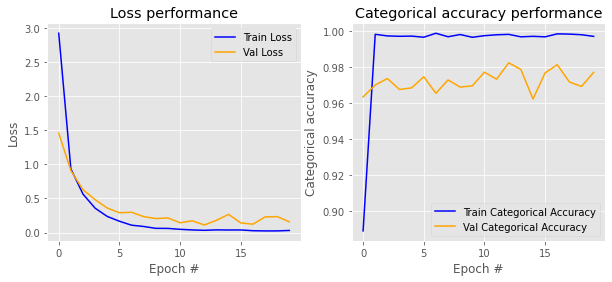

89/89 [==============================] - 8s 94ms/step - loss: 0.1525 - categorical_accuracy: 0.9768
Final accuracy: 0.9768342971801758


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+256 WITH DROPOUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 131)               33667     
Total params: 15,928,259
Trainable params: 8,292,995
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 172s 324ms/step - loss: 5.3677 - categorical_accuracy: 0.3119 - val_loss: 0.1676 - val_categorical_accuracy: 0.9673
Epoch 2/20
529/529 [==============================] - 168s 318ms/step - loss: 0.0222 - categorical_accuracy: 0.9939 - val_loss: 0.2548 - val_categorical_accuracy: 0.9704
Epoch 3/20
529/529 [==============================] - 169s 319ms/step - loss: 0.0079 - categorical_accuracy: 0.9981 - val_loss: 0.1744 - val_categorical_accuracy: 0.9778
Epoch 4/20
529/529 [==============================] - 170s 321ms/step - loss: 0.0092 - categorical_accuracy: 0.9977 - val_loss: 0.1965 - val_categorical_accuracy: 0.9783
Epoch 5/20
529/529 [==============================] - 169s 320ms/step - loss: 0.0116 - categorical_accuracy: 0.9976 - val_loss: 0.2530 - val_categorical_accuracy: 0.9744
Epoch 6/20
529/529 [==============================] - 169s 319ms/step - loss: 0.0168 - categorical_accuracy: 0.9966 - val_loss: 0.2426 - val_categoric

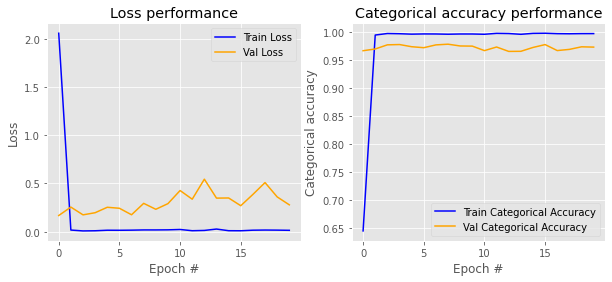

89/89 [==============================] - 8s 93ms/step - loss: 0.3016 - categorical_accuracy: 0.9734
Final accuracy: 0.9733991026878357


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512 WITHOUT REGULARIZATION***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_14 (Dense)             (None, 131)               67203     
Total params: 17,141,699
Trainable params: 9,506,435
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 163s 307ms/step - loss: 3.4838 - categorical_accuracy: 0.3749 - val_loss: 0.4449 - val_categorical_accuracy: 0.8905
Epoch 2/20
529/529 [==============================] - 162s 305ms/step - loss: 0.1223 - categorical_accuracy: 0.9587 - val_loss: 0.3372 - val_categorical_accuracy: 0.9261
Epoch 3/20
529/529 [==============================] - 162s 305ms/step - loss: 0.0643 - categorical_accuracy: 0.9792 - val_loss: 0.3549 - val_categorical_accuracy: 0.9423
Epoch 4/20
529/529 [==============================] - 161s 305ms/step - loss: 0.0468 - categorical_accuracy: 0.9857 - val_loss: 0.1762 - val_categorical_accuracy: 0.9633
Epoch 5/20
529/529 [==============================] - 161s 304ms/step - loss: 0.0337 - categorical_accuracy: 0.9888 - val_loss: 0.3206 - val_categorical_accuracy: 0.9432
Epoch 6/20
529/529 [==============================] - 161s 305ms/step - loss: 0.0330 - categorical_accuracy: 0.9902 - val_loss: 0.3604 - val_categoric

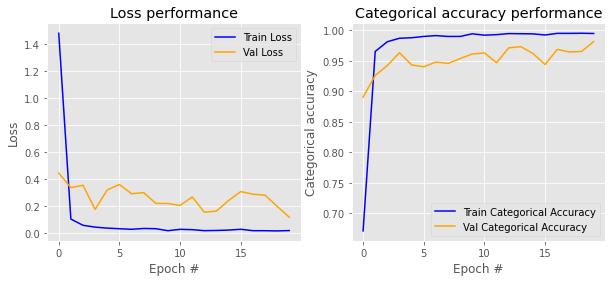

89/89 [==============================] - 8s 92ms/step - loss: 0.1494 - categorical_accuracy: 0.9793
Final accuracy: 0.9793006181716919


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512 WITH REGULARIZATION  L2***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_8 (Dense)              (None, 131)               67203     
Total params: 17,141,699
Trainable params: 9,506,435
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 172s 324ms/step - loss: 8.7322 - categorical_accuracy: 0.6635 - val_loss: 2.0426 - val_categorical_accuracy: 0.9674
Epoch 2/20
529/529 [==============================] - 170s 321ms/step - loss: 1.6338 - categorical_accuracy: 0.9986 - val_loss: 1.3267 - val_categorical_accuracy: 0.9715
Epoch 3/20
529/529 [==============================] - 171s 323ms/step - loss: 1.0278 - categorical_accuracy: 0.9988 - val_loss: 0.9079 - val_categorical_accuracy: 0.9760
Epoch 4/20
529/529 [==============================] - 172s 325ms/step - loss: 0.6619 - categorical_accuracy: 0.9992 - val_loss: 0.5911 - val_categorical_accuracy: 0.9794
Epoch 5/20
529/529 [==============================] - 174s 328ms/step - loss: 0.4333 - categorical_accuracy: 0.9983 - val_loss: 0.4829 - val_categorical_accuracy: 0.9742
Epoch 6/20
529/529 [==============================] - 173s 328ms/step - loss: 0.2813 - categorical_accuracy: 0.9988 - val_loss: 0.4308 - val_categoric

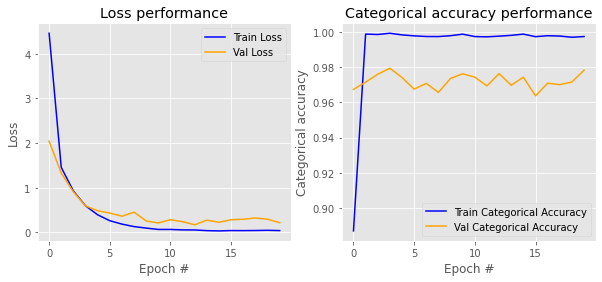

89/89 [==============================] - 8s 93ms/step - loss: 0.2103 - categorical_accuracy: 0.9803
Final accuracy: 0.9802695512771606


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512+256 WITHOUT  DROPOUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 131)               33667     
Total params: 17,239,491
Trainable params: 9,604,227
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 163s 306ms/step - loss: 2.0875 - categorical_accuracy: 0.6606 - val_loss: 0.2164 - val_categorical_accuracy: 0.9658
Epoch 2/20
529/529 [==============================] - 161s 305ms/step - loss: 0.0271 - categorical_accuracy: 0.9934 - val_loss: 0.2216 - val_categorical_accuracy: 0.9639
Epoch 3/20
529/529 [==============================] - 161s 305ms/step - loss: 0.0160 - categorical_accuracy: 0.9958 - val_loss: 0.2087 - val_categorical_accuracy: 0.9695
Epoch 4/20
529/529 [==============================] - 160s 303ms/step - loss: 0.0225 - categorical_accuracy: 0.9946 - val_loss: 0.2418 - val_categorical_accuracy: 0.9669
Epoch 5/20
529/529 [==============================] - 161s 304ms/step - loss: 0.0184 - categorical_accuracy: 0.9955 - val_loss: 0.2300 - val_categorical_accuracy: 0.9604
Epoch 6/20
529/529 [==============================] - 162s 306ms/step - loss: 0.0111 - categorical_accuracy: 0.9975 - val_loss: 0.2617 - val_categoric

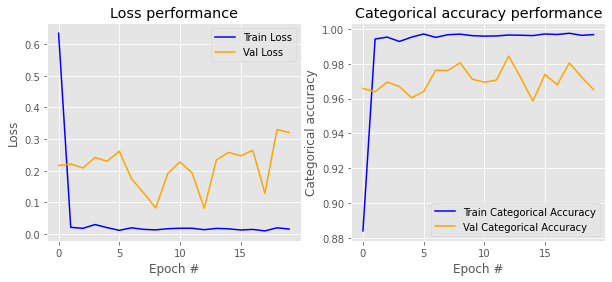

89/89 [==============================] - 8s 92ms/step - loss: 0.3087 - categorical_accuracy: 0.9641
Final accuracy: 0.9640623331069946


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+512+256 WITH REGULARIZATION  DROPOUT***

In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 131)               33667     
Total params: 17,239,491
Trainable params: 9,604,227
Non-trainable params: 7,635,264
___________________________________

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 173s 326ms/step - loss: 5.0924 - categorical_accuracy: 0.3305 - val_loss: 0.2615 - val_categorical_accuracy: 0.9648
Epoch 2/20
529/529 [==============================] - 169s 320ms/step - loss: 0.0144 - categorical_accuracy: 0.9963 - val_loss: 0.2847 - val_categorical_accuracy: 0.9707
Epoch 3/20
529/529 [==============================] - 170s 322ms/step - loss: 0.0062 - categorical_accuracy: 0.9984 - val_loss: 0.2093 - val_categorical_accuracy: 0.9771
Epoch 4/20
529/529 [==============================] - 171s 322ms/step - loss: 0.0067 - categorical_accuracy: 0.9985 - val_loss: 0.1773 - val_categorical_accuracy: 0.9806
Epoch 5/20
529/529 [==============================] - 171s 323ms/step - loss: 0.0151 - categorical_accuracy: 0.9977 - val_loss: 0.2409 - val_categorical_accuracy: 0.9787
Epoch 6/20
529/529 [==============================] - 170s 321ms/step - loss: 0.0067 - categorical_accuracy: 0.9986 - val_loss: 0.2060 - val_categoric

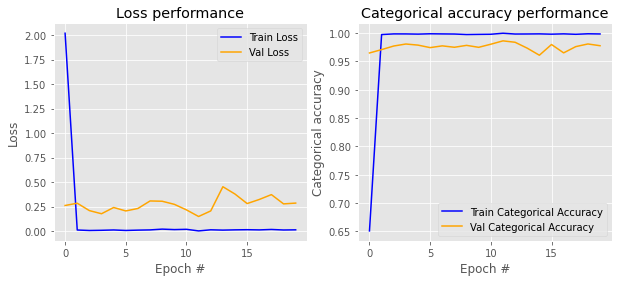

89/89 [==============================] - 8s 92ms/step - loss: 0.3051 - categorical_accuracy: 0.9771
Final accuracy: 0.9770985841751099


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+1024+512+256 WITHOUT DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              4719616   
_________________________________________________________________
dense_26 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_28 (Dense)             (None, 131)               33667     
Total params: 20,124,099
Trainable params: 12,488,835
Non-trainable params: 7,635,264
_________________________________

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 162s 306ms/step - loss: 2.9261 - categorical_accuracy: 0.4223 - val_loss: 0.4357 - val_categorical_accuracy: 0.9027
Epoch 2/20
529/529 [==============================] - 161s 303ms/step - loss: 0.1042 - categorical_accuracy: 0.9669 - val_loss: 0.2485 - val_categorical_accuracy: 0.9470
Epoch 3/20
529/529 [==============================] - 162s 307ms/step - loss: 0.0632 - categorical_accuracy: 0.9804 - val_loss: 0.2315 - val_categorical_accuracy: 0.9483
Epoch 4/20
529/529 [==============================] - 161s 304ms/step - loss: 0.0476 - categorical_accuracy: 0.9852 - val_loss: 0.2267 - val_categorical_accuracy: 0.9484
Epoch 5/20
529/529 [==============================] - 160s 303ms/step - loss: 0.0354 - categorical_accuracy: 0.9889 - val_loss: 0.2535 - val_categorical_accuracy: 0.9490
Epoch 6/20
529/529 [==============================] - 160s 303ms/step - loss: 0.0359 - categorical_accuracy: 0.9890 - val_loss: 0.1727 - val_categoric

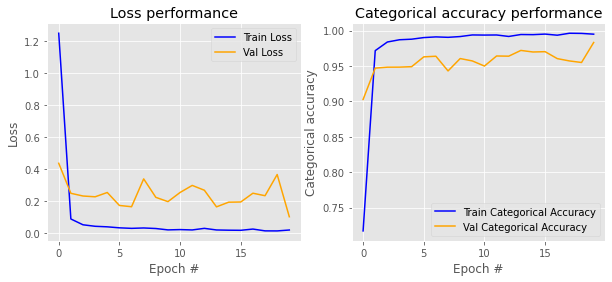

89/89 [==============================] - 8s 92ms/step - loss: 0.1159 - categorical_accuracy: 0.9818
Final accuracy: 0.981766939163208


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

###### ***+1024+512+256 WITH DROPOUT***

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              4719616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)              

In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time
vgg16_pipe.compile(EPOCHS, [])

Epoch 1/20
529/529 [==============================] - 163s 308ms/step - loss: 2.4185 - categorical_accuracy: 0.6315 - val_loss: 0.1447 - val_categorical_accuracy: 0.9748
Epoch 2/20
529/529 [==============================] - 162s 305ms/step - loss: 0.0163 - categorical_accuracy: 0.9954 - val_loss: 0.1779 - val_categorical_accuracy: 0.9742
Epoch 3/20
529/529 [==============================] - 162s 305ms/step - loss: 0.0204 - categorical_accuracy: 0.9961 - val_loss: 0.1446 - val_categorical_accuracy: 0.9772
Epoch 4/20
529/529 [==============================] - 162s 306ms/step - loss: 0.0162 - categorical_accuracy: 0.9959 - val_loss: 0.1268 - val_categorical_accuracy: 0.9773
Epoch 5/20
529/529 [==============================] - 161s 304ms/step - loss: 0.0135 - categorical_accuracy: 0.9972 - val_loss: 0.1968 - val_categorical_accuracy: 0.9739
Epoch 6/20
529/529 [==============================] - 160s 302ms/step - loss: 0.0174 - categorical_accuracy: 0.9963 - val_loss: 0.2108 - val_categoric

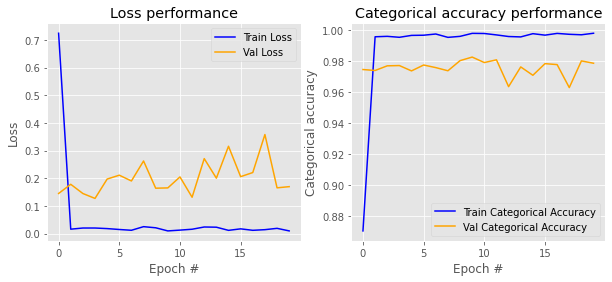

89/89 [==============================] - 8s 93ms/step - loss: 0.1540 - categorical_accuracy: 0.9778
Final accuracy: 0.9778032302856445


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
del vgg16_pipe.new_model

### ***EXPLOITATION***
---

___Hyperparameter selection___ <br>
For each approach, we perform several types of models with different architectures starting from the simplest to more complex ones with the following reasonable hyperparameters:
- `learning_rate = 1e-4` with `keras.optimizer = Adam()`
- `epochs = 20`
- `batch_size = 128` <br><br>
Then, once we select the two best models for each approach, an _hyperparameter tuning_ is performed in order to improve performances and understand how much an hyperparemter affects the solution. <br> <br>
Let's analyse the hyperparameter tuning for __the first approach__.
The _batch size_ isn't so important in the long-term because results obtained with different values converges. On the other hand, speakinh about the short-term period, there are some differences that fade after 4 epochs. 
The best training loss value is the one with 32 batches because it is associated to the lowest curve in the intial phase. However, when the categorical accuracy for the validation set is considered, 64 or 128 batches are the best values because thay have less variance. 128 is preferable because it can give a less biased estimate of the gradient of the loss function in the training phase  <br>
When _learning rate_ is too high (0.01) models doesn't learn appropriately: indeed, the categorical accuracy is constant. 
On the other hand, learning rate equal to 1e-5 learns slowly and for this reason, use 1e-4 or 1e-3 values are better choices. <br><br>
The same considerations about the batch size and th learning rate remain true also for the __second approach__. 





#### ***FIRST BEST MODEL***

##### ***CHANGING THE BATCH SIZE***

In [ ]:
%%time
#--- CHANGE BATCH SIZE.
BATCH_SIZE_TRIALS = [32, 64, 128, 256]
LEARNING_RATE = 1e-4
EPOCHS_TUNING = 10
results = []

for elem in BATCH_SIZE_TRIALS:
  print(f"\t\t\t\t\t\t ***** BATCH SIZE: {elem} *****")
  conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

  for layer in conv_base.layers:
    layer.trainable = False

  # Define object.
  vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, LEARNING_RATE, 0)
  # Load data.
  vgg16_pipe.split_train_val_test(elem, data_augm = 1)
  # Better model
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu', kernel_initializer=initializer))
  model.add(Dense(num_classes, activation='softmax'))
  # Save the new model.
  vgg16_pipe.fine_tuning(model)

  vgg16_pipe.compile(EPOCHS_TUNING, [])

  results.append({'Batch': elem, 'History': vgg16_pipe.H})

  del vgg16_pipe.new_model

						 ***** BATCH SIZE: 32 *****
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/10
2116/2116 [==============================] - 173s 82ms/step - loss: 4.0271 - categorical_accuracy: 0.4326 - val_loss: 0.6287 - val_categorical_accuracy: 0.8545
Epoch 2/10
2116/2116 [==============================] - 173s 82ms/step - loss: 0.3300 - categorical_accuracy: 0.9016 - val_loss: 0.4169 - val_categorical_accuracy: 0.9200
Epoch 3/10
2116/2116 [==============================] - 172s 81ms/step - loss: 0.1802 - categorical_accuracy: 0.9446 - val_loss: 0.3590 - val_categorical_accuracy: 0.9300
Epoch 4/10
2116/2116 [==============================] - 173s 82ms/step - loss: 0.1354 - categorical_accuracy: 0.9595 - val_loss: 0.4089 - val_categorical_accuracy: 0.9264
Epoch 5/10
2116/2116 [==============================] - 172s 81ms/step - loss: 0.1122 - categorical_accuracy: 0.9665 - val_loss: 0.3594 - val_categ

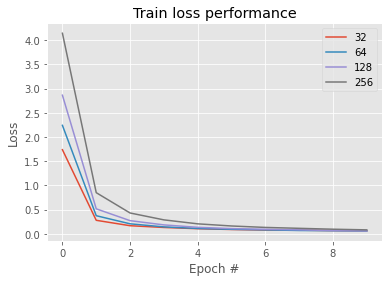

In [ ]:
for elem in results:
  plt.plot(elem['History'].history["loss"], label = elem['Batch'])
  plt.title("Train loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/train_loss.jpg')

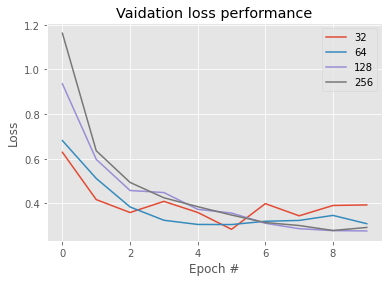

In [ ]:
for elem in results:
  plt.plot(elem['History'].history["val_loss"], label = elem['Batch'])
  plt.title("Vaidation loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_train_loss.jpg')

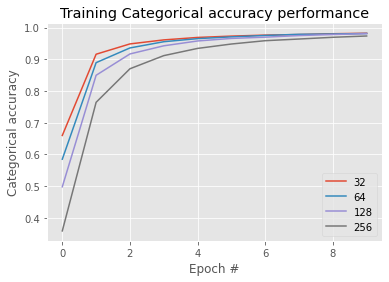

In [ ]:
for elem in results:
  plt.plot(elem['History'].history["categorical_accuracy"], label = elem['Batch'])
  plt.title("Training Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/categorical_accuracy.jpg')

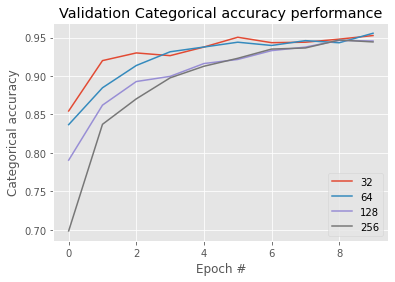

In [ ]:
for elem in results:
  plt.plot(elem['History'].history["val_categorical_accuracy"], label = elem['Batch'])
  plt.title("Validation Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_categorical_accuracy.jpg')

##### ***CHANGING THE LEARNING RATE***

In [ ]:
%%time
# -- LEARNING RATE TRIALS.
LEARNING_RATE = [1e-2, 1e-3, 1e-4, 1e-5]
BATCH_SIZE = 128
EPOCHS_TUNING = 10
results_lr = []

for elem in LEARNING_RATE:
  print(f"\t\t\t\t\t\t ***** LEARNING RATE: {elem} *****")
  conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

  for layer in conv_base.layers:
    layer.trainable = False

  # Define object.
  vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, elem, RANDOM_STATE)
  vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 1)
  
  # Better model
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu', kernel_initializer=initializer))
  model.add(Dense(num_classes, activation='softmax'))

  # Save the new model.
  vgg16_pipe.fine_tuning(model)

  vgg16_pipe.compile(EPOCHS_TUNING, [])

  results_lr.append({'Learning rate': elem, 'History': vgg16_pipe.H})

  del vgg16_pipe.new_model

						 ***** LEARNING RATE: 0.01 *****
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/10
529/529 [==============================] - 163s 303ms/step - loss: 11.0513 - categorical_accuracy: 0.1787 - val_loss: 2.0429 - val_categorical_accuracy: 0.3938
Epoch 2/10
529/529 [==============================] - 156s 295ms/step - loss: 2.5045 - categorical_accuracy: 0.3434 - val_loss: 2.0149 - val_categorical_accuracy: 0.4119
Epoch 3/10
529/529 [==============================] - 156s 294ms/step - loss: 2.3817 - categorical_accuracy: 0.3659 - val_loss: 2.0624 - val_categorical_accuracy: 0.4411
Epoch 4/10
529/529 [==============================] - 156s 295ms/step - loss: 2.4412 - categorical_accuracy: 0.3606 - val_loss: 1.9226 - val_categorical_accuracy: 0.4513
Epoch 5/10
529/529 [==============================] - 157s 297ms/step - loss: 2.5009 - categorical_accuracy: 0.3591 - val_loss: 2.0216 - val_cate

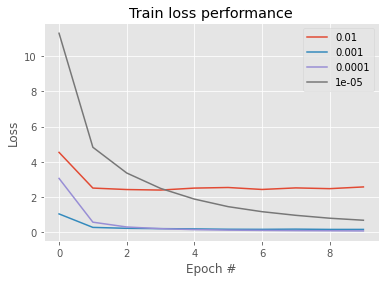

In [ ]:
for elem in results_lr:
  plt.plot(elem['History'].history["loss"], label = elem['Learning rate'])
  plt.title("Train loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/train_loss_lr.jpg')

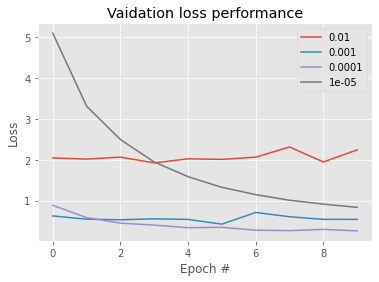

In [ ]:
for elem in results_lr:
  plt.plot(elem['History'].history["val_loss"], label = elem['Learning rate'])
  plt.title("Vaidation loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_train_loss_lr.jpg')

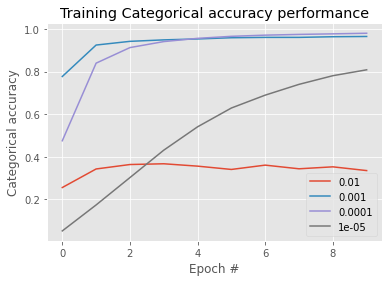

In [ ]:
for elem in results_lr:
  plt.plot(elem['History'].history["categorical_accuracy"], label = elem['Learning rate'])
  plt.title("Training Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/categorical_accuracy_lr.jpg')

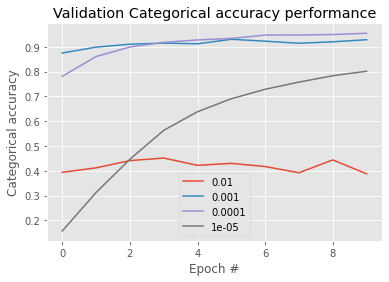

In [ ]:
for elem in results_lr:
  plt.plot(elem['History'].history["val_categorical_accuracy"], label = elem['Learning rate'])
  plt.title("Validation Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_categorical_accuracy_lr.jpg')

#### ***MIGLIOR SECONDO MODELLO***

##### ***CHANGING THE BATCH SIZE***

In [ ]:
%%time
# -- BATCH SIZE TRIALS.
BATCH_SIZE_TRIALS = [32, 64, 128, 256]
EPOCHS_TUNING = 10
LEARNING_RATE = 1e-4
results_conv = []

for elem in BATCH_SIZE_TRIALS:
  print(f"\t\t\t\t\t\t ***** BATCH SIZE: {elem} *****")
  conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

  conv_base.trainable = True

  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f"Layer {layer.name}, trainable? {layer.trainable}")

  # Define object.
  vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, LEARNING_RATE, RANDOM_STATE)
  # Load data.
  vgg16_pipe.split_train_val_test(elem, data_augm = 1)
  # Better model
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_regularizer = l2(0.01), kernel_initializer=initializer))
  model.add(Dense(num_classes, activation='softmax'))
  # Save the new model.
  vgg16_pipe.fine_tuning(model)

  vgg16_pipe.compile(EPOCHS_TUNING, [])

  results_conv.append({'Batch': elem, 'History': vgg16_pipe.H})

  del vgg16_pipe.new_model

						 ***** BATCH SIZE: 32 *****
Layer input_7, trainable? False
Layer block1_conv1, trainable? False
Layer block1_conv2, trainable? False
Layer block1_pool, trainable? False
Layer block2_conv1, trainable? False
Layer block2_conv2, trainable? False
Layer block2_pool, trainable? False
Layer block3_conv1, trainable? False
Layer block3_conv2, trainable? False
Layer block3_conv3, trainable? False
Layer block3_pool, trainable? False
Layer block4_conv1, trainable? False
Layer block4_conv2, trainable? False
Layer block4_conv3, trainable? False
Layer block4_pool, trainable? False
Layer block5_conv1, trainable? True
Layer block5_conv2, trainable? True
Layer block5_conv3, trainable? True
Layer block5_pool, trainable? True
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/10
2116/2116 [==============================] - 177s 83ms/step - loss: 5.7375 - categorical_accuracy: 0.5477 - val_loss: 0.8345 - val_

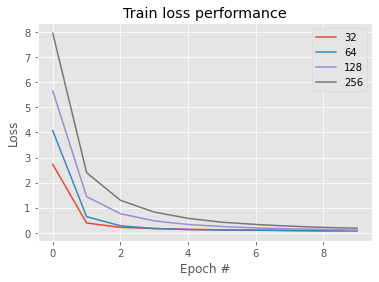

In [ ]:
for elem in results_conv:
  plt.plot(elem['History'].history["loss"], label = elem['Batch'])
  plt.title("Train loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/train_loss_conv.jpg')

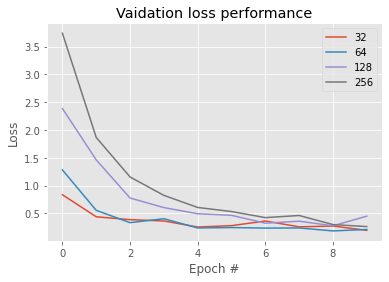

In [ ]:
for elem in results_conv:
  plt.plot(elem['History'].history["val_loss"], label = elem['Batch'])
  plt.title("Vaidation loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_train_loss_conv.jpg')

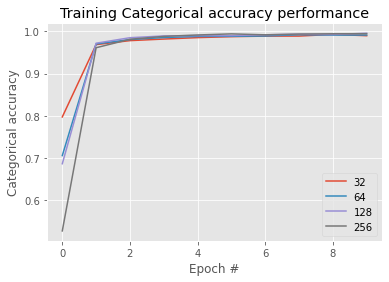

In [ ]:
for elem in results_conv:
  plt.plot(elem['History'].history["categorical_accuracy"], label = elem['Batch'])
  plt.title("Training Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/categorical_accuracy_conv.jpg')

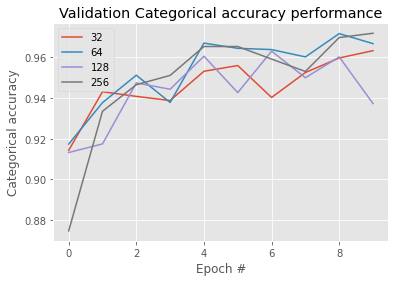

In [ ]:
for elem in results_conv:
  plt.plot(elem['History'].history["val_categorical_accuracy"], label = elem['Batch'])
  plt.title("Validation Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_categorical_accuracy_conv.jpg')

##### ***CHANGING THE LEARNING RATE***

In [ ]:
%%time
# -- LEARNING RATE TRIALS.
LEARNING_RATE = [1e-2, 1e-3, 1e-4, 1e-5]
BATCH_SIZE = 128
EPOCHS_TUNING = 10
results_conv_lr = []

for elem in LEARNING_RATE:
  print(f"\t\t\t\t\t\t ***** LEARNING RATE: {elem} *****")
  conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

  conv_base.trainable = True

  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f"Layer {layer.name}, trainable? {layer.trainable}")

  # Define object.
  vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess,  PATH, elem, RANDOM_STATE)
  # Load data.
  vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 1)
  # Better model
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_regularizer = l2(0.01), kernel_initializer=initializer))
  model.add(Dense(num_classes, activation='softmax'))

  # Save the new model.
  vgg16_pipe.fine_tuning(model)

  vgg16_pipe.compile(EPOCHS_TUNING, [])

  results_conv_lr.append({'Learning rate': elem, 'History': vgg16_pipe.H})

  del vgg16_pipe.new_model

						 ***** LEARNING RATE: 0.01 *****
Layer input_12, trainable? False
Layer block1_conv1, trainable? False
Layer block1_conv2, trainable? False
Layer block1_pool, trainable? False
Layer block2_conv1, trainable? False
Layer block2_conv2, trainable? False
Layer block2_pool, trainable? False
Layer block3_conv1, trainable? False
Layer block3_conv2, trainable? False
Layer block3_conv3, trainable? False
Layer block3_pool, trainable? False
Layer block4_conv1, trainable? False
Layer block4_conv2, trainable? False
Layer block4_conv3, trainable? False
Layer block4_pool, trainable? False
Layer block5_conv1, trainable? True
Layer block5_conv2, trainable? True
Layer block5_conv3, trainable? True
Layer block5_pool, trainable? True
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/10
529/529 [==============================] - 159s 300ms/step - loss: 2677.6848 - categorical_accuracy: 0.0120 - val_loss: 13.34

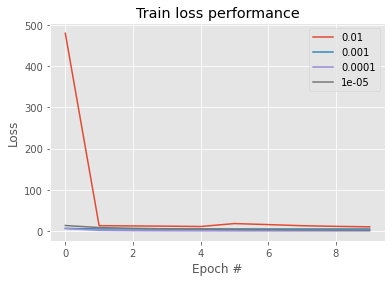

In [ ]:
for elem in results_conv_lr:
  plt.plot(elem['History'].history["loss"], label = elem['Learning rate'])
  plt.title("Train loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/train_loss_lr_conv.jpg')

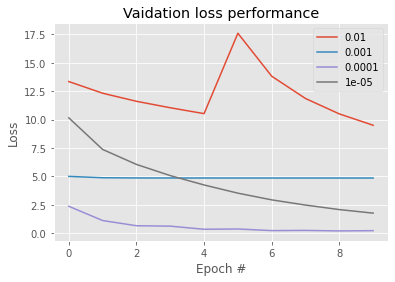

In [ ]:
for elem in results_conv_lr:
  plt.plot(elem['History'].history["val_loss"], label = elem['Learning rate'])
  plt.title("Vaidation loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_train_loss_lr_conv.jpg')

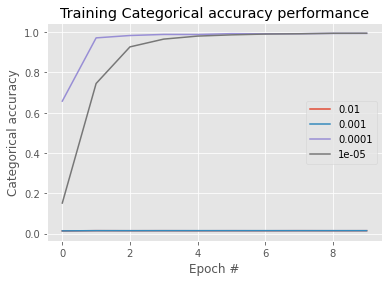

In [ ]:
for elem in results_conv_lr:
  plt.plot(elem['History'].history["categorical_accuracy"], label = elem['Learning rate'])
  plt.title("Training Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/categorical_accuracy_lr_conv.jpg')

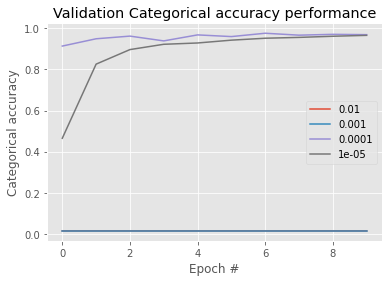

In [ ]:
for elem in results_conv_lr:
  plt.plot(elem['History'].history["val_categorical_accuracy"], label = elem['Learning rate'])
  plt.title("Validation Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_categorical_accuracy_lr_conv.jpg')

##### ***CHANGING THE REULARIZATION HYPERPARAMETER***

In [ ]:
%%time

# -- REGULARIZATION TRIALS.
REG_RATE = [0.1, 0.05, 0.01, 0.001]

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS_TUNING = 10
results_conv_reg = []

for elem in REG_RATE:
  print(f"\t\t\t\t\t\t ***** REGULARIZATION HYPERPARAMETER: {elem} *****")
  conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

  conv_base.trainable = True

  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f"Layer {layer.name}, trainable? {layer.trainable}")

  # Define object.
  vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess,  PATH, LEARNING_RATE, 0)
  # Load data.
  vgg16_pipe.split_train_val_test(BATCH_SIZE, data_augm = 1)
  # Better model
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_regularizer = l2(elem), kernel_initializer=initializer))
  model.add(Dense(num_classes, activation='softmax'))

  # Save the new model.
  vgg16_pipe.fine_tuning(model)

  vgg16_pipe.compile(EPOCHS_TUNING, [])

  results_conv_reg.append({'Regularization hyperparameter': elem, 'History': vgg16_pipe.H})

  del vgg16_pipe.new_model

						 ***** REGULARIZATION HYPERPARAMETER: 0.1 *****
Layer input_16, trainable? False
Layer block1_conv1, trainable? False
Layer block1_conv2, trainable? False
Layer block1_pool, trainable? False
Layer block2_conv1, trainable? False
Layer block2_conv2, trainable? False
Layer block2_pool, trainable? False
Layer block3_conv1, trainable? False
Layer block3_conv2, trainable? False
Layer block3_conv3, trainable? False
Layer block3_pool, trainable? False
Layer block4_conv1, trainable? False
Layer block4_conv2, trainable? False
Layer block4_conv3, trainable? False
Layer block4_pool, trainable? False
Layer block5_conv1, trainable? True
Layer block5_conv2, trainable? True
Layer block5_conv3, trainable? True
Layer block5_pool, trainable? True
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/10
529/529 [==============================] - 161s 304ms/step - loss: 51.4579 - categorical_accuracy: 0.3948 - va

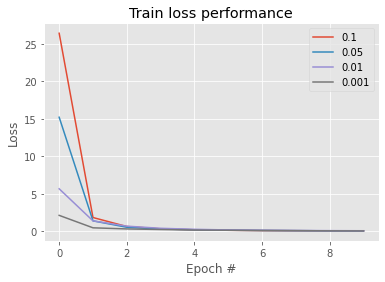

In [ ]:
for elem in results_conv_reg:
  plt.plot(elem['History'].history["loss"], label = elem['Regularization hyperparameter'])
  plt.title("Train loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/train_loss_reg_conv.jpg')

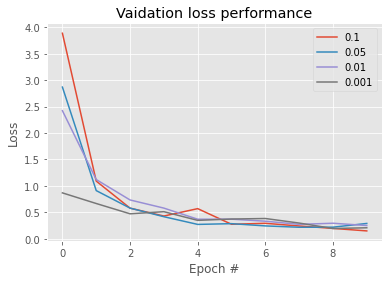

In [ ]:
for elem in results_conv_reg:
  plt.plot(elem['History'].history["val_loss"], label = elem['Regularization hyperparameter'])
  plt.title("Vaidation loss performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_train_loss_reg_conv.jpg')

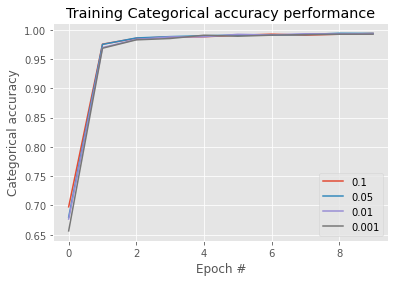

In [ ]:
for elem in results_conv_reg:
  plt.plot(elem['History'].history["categorical_accuracy"], label = elem['Regularization hyperparameter'])
  plt.title("Training Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/categorical_accuracy_reg_conv.jpg')

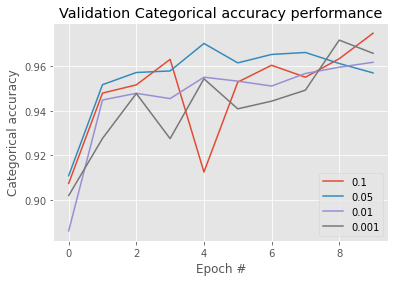

In [ ]:
for elem in results_conv_reg:
  plt.plot(elem['History'].history["val_categorical_accuracy"], label = elem['Regularization hyperparameter'])
  plt.title("Validation Categorical accuracy performance")
  plt.xlabel("Epoch #")
  plt.ylabel("Categorical accuracy")
  plt.legend()
  plt.savefig('drive/MyDrive/AML-Project/Fine_Tuning_Images/val_categorical_accuracy_reg_conv.jpg')

### ***BEST MODEL***


In [ ]:
BEST_LR = 1e-4
BEST_BATCH_SIZE = 128
BEST_REG = 0.01
BEST_EPOCHS = 100

In [ ]:
#-- BASE MODEL.
conv_base = vgg16.VGG16(weights='imagenet', 
                        include_top = False, 
                        input_shape = (HEIGHT,WIDTH,3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f"Layer {layer.name}, trainable? {layer.trainable}")

# Define object.
vgg16_pipe = pipeline_fine_tuning([HEIGHT, WIDTH, CHANNEL], preprocess, PATH, BEST_LR, RANDOM_STATE)
# Split dataset. 
vgg16_pipe.split_train_val_test(BEST_BATCH_SIZE, data_augm = 1)

Layer input_21, trainable? False
Layer block1_conv1, trainable? False
Layer block1_conv2, trainable? False
Layer block1_pool, trainable? False
Layer block2_conv1, trainable? False
Layer block2_conv2, trainable? False
Layer block2_pool, trainable? False
Layer block3_conv1, trainable? False
Layer block3_conv2, trainable? False
Layer block3_conv3, trainable? False
Layer block3_pool, trainable? False
Layer block4_conv1, trainable? False
Layer block4_conv2, trainable? False
Layer block4_conv3, trainable? False
Layer block4_pool, trainable? False
Layer block5_conv1, trainable? True
Layer block5_conv2, trainable? True
Layer block5_conv3, trainable? True
Layer block5_pool, trainable? True
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


In [ ]:
#-- FINE-TUNING.

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer = l2(BEST_REG), kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_20 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_46 (Dense)             (None, 131)               67203     
Total params: 17,141,699
Trainable params: 9,506,435
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Save the new model.
vgg16_pipe.fine_tuning(model)

In [ ]:
%%time

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
]

vgg16_pipe.compile(BEST_EPOCHS, my_callbacks)

Epoch 1/100
529/529 [==============================] - 160s 302ms/step - loss: 9.8167 - categorical_accuracy: 0.3294 - val_loss: 2.2941 - val_categorical_accuracy: 0.9037
Epoch 2/100
529/529 [==============================] - 160s 302ms/step - loss: 1.6087 - categorical_accuracy: 0.9651 - val_loss: 1.1247 - val_categorical_accuracy: 0.9423
Epoch 3/100
529/529 [==============================] - 159s 301ms/step - loss: 0.7304 - categorical_accuracy: 0.9834 - val_loss: 0.6661 - val_categorical_accuracy: 0.9413
Epoch 4/100
529/529 [==============================] - 158s 298ms/step - loss: 0.4124 - categorical_accuracy: 0.9882 - val_loss: 0.5098 - val_categorical_accuracy: 0.9361
Epoch 5/100
529/529 [==============================] - 159s 300ms/step - loss: 0.2791 - categorical_accuracy: 0.9870 - val_loss: 0.3587 - val_categorical_accuracy: 0.9608
Epoch 6/100
529/529 [==============================] - 159s 300ms/step - loss: 0.1983 - categorical_accuracy: 0.9915 - val_loss: 0.2874 - val_cat

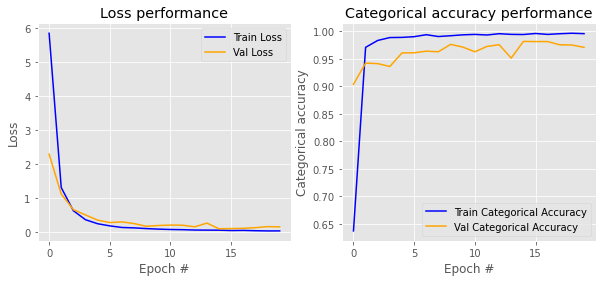

89/89 [==============================] - 8s 90ms/step - loss: 0.1161 - categorical_accuracy: 0.9795
Final accuracy: 0.979476809501648


In [ ]:
vgg16_pipe.evaluation()

In [ ]:
vgg16_pipe.new_model.save('drive/MyDrive/AML-Project/Fine_Tuning_models/best_final_model')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/Fine_Tuning_models/best_final_model/assets
